<a href="https://colab.research.google.com/github/AndersonAraujoX/Rede_Complexa/blob/main/Rede_complexas_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relatório final

Nome: Anderson Araujo de Oliveira

N USP° 11371311




# Bibliotecas Utilizadas



In [ ]:
!pip install algorithmx #Biblioteca montar grafos em javascript
!pip install igraph #Biblioteca metricas de rede neurais mais otimizada
!pip install karateclub #biblioteca para obter algumas funções de classificações de nó
!pip install umap-learn #auxilia kakrateclub

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import numpy as np
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import random as random
from algorithmx import jupyter_canvas
from google.colab import output
from networkx.algorithms.community.centrality import girvan_newman
from sklearn.decomposition import PCA
from scipy.linalg import eigh
import operator
#from algorithmx import jupyter_canvas
from google.colab import output
import time
import collections
from sklearn.cluster import DBSCAN
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

#bibliotecas para os classificadores
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

output.enable_custom_widget_manager()

In [ ]:
#cuidado algumas partes do código não funciona se rodar essa parte!

class GraphAPI():
    def __init__(self, graph): self.data = graph
    def __len__(self): return self.count_nodes() + self.count_edges()

    def _isnx(self): return isinstance(self.data, nx.Graph)
    def _isig(self): return isinstance(self.data, ig.Graph)
    def _isint(self, var): return isinstance(var, int)
    def _islst(self, var): return isinstance(var, list)
    def _istpl(self, var): return isinstance(var, tuple)

    def nodes(self):
        if   self._isnx(): return list(self.data.nodes)
        elif self._isig(): return list([ v.index for v in self.data.vs ])
        else:              return []

    def edges(self):
        if   self._isnx(): return list(self.data.edges)
        elif self._isig(): return list([ e.tuple for e in self.data.es ])
        else:              return []

    def neighbors(self, u):
        if   self._isnx(): return list(self.data.neighbors(u))
        elif self._isig(): return self.data.neighbors(u)
        else:              return []

    def to_adj_matrix(self):
        if   self._isnx(): return nx.to_numpy_array(self.data)
        elif self._isig(): return np.array(list(self.data.get_adjacency()))
        else:              return np.array([[]])

    def degree(self, param=None):
        if   self._isnx() and param is None     : return nx.degree(self.data)
        if   self._isnx() and self._isint(param): return nx.degree(self.data, param)
        elif self._isnx() and self._islst(param): return nx.degree(self.data, param)
        elif self._isig() and param is None     : return [ (u,k) for u,k in enumerate(self.data.degree()) ]
        elif self._isig() and self._isint(param): return self.data.degree(param)
        elif self._isig() and self._islst(param): return [ (u,k) for u,k in zip(param, self.data.degree(param)) ]

        return

    def copy(self):
        return GraphAPI(self.data.copy())

    def resume(self, dtype=True):
        dtype_str = f'{type(self.data)}\n' if dtype else ''
        return f'{dtype_str}{self.count_nodes()} nodes, {self.count_edges()} edges'

    def add_node(self, param):
        if   self._isnx() and self._isint(param): self.data.add_node(param)
        elif self._isnx() and self._islst(param): self.data.add_nodes_from(param)
        elif self._isig() and self._isint(param): self.data.add_vertex(param)
        elif self._isig() and self._islst(param): self.data.add_vertices(param)
        else: raise

    def add_edge(self, param):
        if   self._isnx() and self._istpl(param): self.data.add_edge(*param)
        elif self._isnx() and self._islst(param): self.data.add_edges_from(param)
        elif self._isig() and self._istpl(param): self.data.add_edge(*param)
        elif self._isig() and self._islst(param): self.data.add_edges(param)
        else: raise

    def rmv_edge(self, param):
        if   self._isnx() and self._istpl(param): self.data.remove_edge(*param)
        elif self._isnx() and self._islst(param): self.data.remove_edges_from(param)
        elif self._isig() and self._istpl(param): self.data.delete_edges(self.data.get_eid(*param))
        elif self._isig() and self._islst(param): self.data.delete_edges([ self.data.get_eid(p) for p in param ])
        else: raise

    def count_nodes(self):
        if   self._isnx(): return self.data.number_of_nodes()
        elif self._isig(): return len(self.data.vs)
        else:              return 0

    def count_edges(self):
        if   self._isnx(): return self.data.number_of_edges()
        elif self._isig(): return len(self.data.es)
        else:              return 0

    def draw(self, **kargs):
        if   self._isnx(): return nx.draw(self.data, **kargs)
        elif self._isig(): return ig.plot(self.data, **kargs)
        else             : return None

    @staticmethod
    def generate(engine, style='empty', **kwargs):
        if engine=='networkx' or engine=='nx':
            if   style=='ba'    : return GraphAPI(nx.barabasi_albert_graph(**kwargs))
            elif style=='er'    : return GraphAPI(nx.erdos_renyi_graph(**kwargs))
            elif style=='ws'    : return GraphAPI(nx.watts_strogatz_graph(**kwargs))
            elif style=='tree'  : return GraphAPI(nx.balanced_tree(**kwargs))
            elif style=='empty' : return GraphAPI(nx.Graph())
            else                : return None
        elif engine=='igraph' or engine=='ig':
            if   style=='ba'    : return GraphAPI(ig.Graph.Barabasi(**kwargs))
            elif style=='er'    : return GraphAPI(ig.Graph.Erdos_Renyi(**kwargs))
            elif style=='ws'    : return GraphAPI(ig.Graph.Watts_Strogatz(**kwargs))
            elif style=='tree'  : return GraphAPI(ig.Graph.Tree(**kwargs))
            elif style=='empty' : return GraphAPI(ig.Graph())
            else                : return None
        else: raise


In [ ]:
#gerar o grafo do brasil
class GrafoBrasilCovid():

	def __init__(self, caminho='dados/gerado/'):
		self.caminho = caminho
		self.load()

	def load(self):
		# dados brutos
		self.sobre = pd.read_csv(self.caminho + 'atrib_extra.csv')
		self.estat = pd.read_csv(self.caminho + 'atrib_estat.csv')
		self.dinam = pd.read_csv(self.caminho + 'atrib_dinam.csv')
		self.conex = pd.read_csv(self.caminho + 'lista_rel.csv')

		# dados derivados
		qt = int(self.sobre[ self.sobre['atrib']=='dias' ]['valor'].values[0])
		di = self.sobre[ self.sobre['atrib']=='data_inicio' ]['valor'].values[0]
		dt = self.sobre[ self.sobre['atrib']=='data_termino' ]['valor'].values[0]
		self.datas = pd.DataFrame({
		    'dia':range(1, qt+1),
		    'data': pd.date_range(start=di, end=dt)
		})

	def draw_map(self, layers=['AER','FER','HID','ROD','FRO','MUN'], fs=(16,16)):
		params = {
			'FRO': {'colors': 'brown',  'alpha': 0.5},
			'ROD': {'colors': 'purple', 'alpha': 0.5},
			'HID': {'colors': 'blue',   'alpha': 0.6},
			'FER': {'colors': 'red',    'alpha': 0.6},
			'AER': {'colors': 'orange', 'alpha': 0.5}
		}

		pos = { v: (lng, lat) for (v, lng, lat) in self.estat.set_index('geocodigo')[['lng', 'lat']].to_records() }
		lim_lng = [ self.estat['lng'].min()-1, self.estat['lng'].max()+1 ]
		lim_lat = [ self.estat['lat'].min()-1, self.estat['lat'].max()+1 ]

		fig, ax = plt.subplots(1,1,figsize=fs)
		plt.rcParams.update({'font.size': 16})
		hdl = []

		if 'MUN' in layers:
			lng = self.estat['lng'].values
			lat = self.estat['lat'].values
			hdl.append(plt.scatter(lng, lat, color='green', alpha=0.6, label='municípios'))

		for m in params:
			if m not in layers:
				continue

			E = self.conex[ self.conex[m] ][['geocodigo_1', 'geocodigo_2']].to_records(index=False)
			segs = [ [ pos[v] for v in e ] for e in E ]
			lcoll = LineCollection(segs, linewidth=1, linestyles='solid', **params[m])
			ax.add_collection(lcoll)
			hdl.append(Line2D([], [], color=params[m]['colors'], label=m))

		plt.xlabel('Longitude (graus)')
		plt.ylabel('Latitude (graus)')
		plt.xlim(lim_lng)
		plt.ylim(lim_lat)
		plt.legend(handles=hdl)
		plt.tight_layout()
		plt.show()

	def to_dataframe(self):
		df = self.estat.merge(self.datas.merge(self.dinam, on='dia'), on='geocodigo')
		df.set_index(['geocodigo','dia'], inplace=True)
		return df

	def to_graph(self, format=None):
		# vértices/nós
		V_cols = list(set(self.dinam.columns) - set(['geocodigo', 'dia']))
		V = self.estat.set_index('geocodigo', drop=True).to_dict(orient='index')
		for m in V:
		    f = (self.dinam['geocodigo']==m)
		    V[m].update({ c: self.dinam[f][c].values for c in V_cols })

		# arestas/conexões
		E_aux = pd.concat([
		    self.conex.rename(columns={'geocodigo_1': 'de', 'geocodigo_2': 'para'}),
		    self.conex.rename(columns={'geocodigo_2': 'de', 'geocodigo_1': 'para'})
		], ignore_index=True).drop_duplicates()
		E_cols = ['de', 'para', 'distancia']

		M = E_aux[ list(set(E_aux.columns) - set(E_cols)) ].to_dict(orient='list')
		E = { m: list(E_aux[ M[m] ][E_cols].to_records(index=False)) for m in M }

		if format is None:
			return V, E
		elif format == 'networkx':
			G = nx.Graph()
			G.add_nodes_from(V)
			nx.set_node_attributes(G, V)

			for m in E:
				G.add_weighted_edges_from(E[m], malha=m)

			return G

	def to_tensor(self):
		return None


In [ ]:
from google.colab import drive#acessar o google drive
drive.mount('/content/drive')

Mounted at /content/drive


# Notações utilizada

Notações que vamos utilizar durante o relatório

| Simbolos | Descrição |
| --- | --- |
| Ŋ(G) | Conjuto de vertices para o grafo |
| ɛ(G) | Conjuto de arestas do grafo|
| N | Números de vertices|
| M | Números de arestas|
|W | matriz de peso|
| $w_{ij}$| elemento de matriz de peso |
|A| matriz de adjecência|
|$a_{ij}$| elemento da matriz de adjacência|
|k_{i}| grau do vertice|

As notações utilizadas para definir as métricas clássicas.O grau de um vértice i, denotado por $k_{i}$, é o número de arestas conectadas a esse vértice. Para uma rede não direcionada, temos:
\begin{equation}
    k_{i} = \sum_{j} a_{ij} = \sum_{j} a_{ji}
\end{equation}

O grau médio de uma rede é a média de $k_{i}$ para todos os vértices na rede,
\begin{equation}
    <h_{i}> = \frac{1}{N} \sum_{i} k_{i}
\end{equation}
Outras notações que utilizamos durante nossas definições de métricas.

# Grafos utilizados

- Strogatz-Watt

O modelo de Watts-Strogatz é um modelo aleatório de geração de grafos que produz grafos com propriedades de pequeno mundo, incluindo comprimentos de trajeto médios curtos e alta clustering.

- Erdos-Renyis

O modelo Erdõs-Rényi é um dos dois modelos estritamente relacionados para gerar grafos aleatórios, que inclui o limite entre cada par de nós com igual probabilidade, independentemente das extremidades.

- Barabasi-Albert

O modelo de Barabási–Albert (BA) é um algoritmo para gerar redes sem escala de forma aleatória: a rede cresce através da inclusão de novos nós no decorrer do tempo, e esses novos nós se ligam aos nós já existentes na rede com probabilidade proporcional ao grau.

- Karate Club

O Karate Club é uma biblioteca de extensão de aprendizado de máquina não supervisionada para NetworkX.

In [ ]:
Sw=nx.watts_strogatz_graph(30,5,0.01)
Er=nx.erdos_renyi_graph(30,0.1)
Ba=nx.barabasi_albert_graph(30,3)
Kc=nx.karate_club_graph()

In [ ]:
canvas = jupyter_canvas()

canvas.nodes(Sw.nodes).add(color="orange")
canvas.edges(Sw.edges).add()

canvas

JupyterWidget(events=['{"attrs": {"nodes": {"0": {"color": "orange"}, "1": {"color": "orange"}, "2": {"color":…

In [ ]:
canvas = jupyter_canvas()

canvas.nodes(Er.nodes).add(color="red")
canvas.edges(Er.edges).add()

canvas

JupyterWidget(events=['{"attrs": {"nodes": {"0": {"color": "red"}, "1": {"color": "red"}, "2": {"color": "red"…

In [ ]:
canvas = jupyter_canvas()

canvas.nodes(Ba.nodes).add(color="blue")
canvas.edges(Ba.edges).add()

canvas

JupyterWidget(events=['{"attrs": {"nodes": {"0": {"color": "blue"}, "1": {"color": "blue"}, "2": {"color": "bl…

In [ ]:
canvas = jupyter_canvas()

canvas.nodes(Kc.nodes).add(color="black")
canvas.edges(Kc.edges).add()

canvas

JupyterWidget(events=['{"attrs": {"nodes": {"0": {"color": "black"}, "1": {"color": "black"}, "2": {"color": "…

# Métricas Clássicas

Diversas métricas foram criadas ao longo tempo que caracterizam suas topológicas únicas que definem sua conectividade e exercem uma influência significativa na dinâmica dos processos realizados na rede. Sendo assim, a análise, diferenciação e síntese de redes complexas dependem do uso de medidas que expressem as características topológicas mais relevantes.

link para o artigo: https://www.tandfonline.com/doi/pdf/10.1080/00018730601170527

## Vulnerabilidade!

Em redes de infra-estrutura, é importante saber quais componentes são cruciais para o funcionamento ideal. Intuitivamente, os vértices críticos de uma rede são os seus hubs, porém há situações em que eles não são necessariamente os mais vitais para o desempenho do sistema ao qual a rede está subjacente.
onde $E$ é a eficiência global da rede original e $E_{i}$ é a eficiência global
após a remoção do vértice i e todas as suas arestas.
\begin{equation}
   V_{i}=\frac{E-E_i}{E}
\end{equation}


Onde a definição a eficiência global é definida da seguinte forma.

\begin{equation}
    E=\frac{1}{N(N-1)}\sum_{i\neq j}\frac{1}{d_{ij}}
\end{equation}

$d_{ij}$ representa a distância geodésica média entre os nós.


In [ ]:
def vulnerability(G):#vulnerabilidade máxima da rede
  vet=[]
  norm=nx.global_efficiency(G)
  for u in G.nodes():
      Aux = nx.Graph()
      Aux.add_edges_from(G.edges())
      Aux.remove_node(u)
      a=(norm-nx.global_efficiency(Aux))/norm
      vet.append(a)
  return max(vet)


In [ ]:
G = nx.karate_club_graph()
Sw=nx.watts_strogatz_graph(50,5,0.1)
Er=nx.erdos_renyi_graph(50,0.2)
Ba=nx.barabasi_albert_graph(50,3)
#Vulnetrebildidade de cada grafo
print('Vulnerabilidade Karate Club:',vulnerability(G))
print('Vulnerabilidade Watts Strogatz:',vulnerability(Sw))
print('Vulnerabilidade Erdos Renyi:',vulnerability(Er))
print('Vulnerabilidade Barabasi Albert:',vulnerability(Ba))

Vulnerabilidade Karate Club: 0.27143590362900766
Vulnerabilidade Watts Strogatz: 0.04870347910392752
Vulnerabilidade Erdos Renyi: 0.011270086281959255
Vulnerabilidade Barabasi Albert: 0.03314000871855594


## Coeficiente Cíclico

Um coeficiente para medir o quão cíclica é uma rede. O coeficiente cíclico local de um vértice i é definido como a média do inverso dos tamanhos dos menores ciclos formados pelo vértice i e seus vizinhos
\begin{equation}
    S_{ijk}= \text{igual ao menor círculo que passa por i, j e k}
\end{equation}


O coeficiente dado por cada vértice é:

\begin{equation}
    \theta_{i}=\frac{2}{k_{i}(k_{i}-1)}\sum_{k>j}\frac{a_{ij}a_{ik}}{S_{ijk}}
\end{equation}

Mas estamos calculando a média.
\begin{equation}
    <\theta>=\frac{1}{N}\sum_i\theta_{i}
\end{equation}


In [ ]:
def cyclic_coefficient(G):
    cyclic_coeffs = []
    for i in G.nodes():
        if G.degree(i) >= 2:
            neighbors = list(G.neighbors(i))
            n = len(neighbors)
            s = 0
            for j in range(n):
                for k in range(j+1, n):
                    if G.has_edge(neighbors[j], neighbors[k]):
                        Sijk = 3
                    else:
                        try:
                            Sijk = nx.shortest_path_length(G, source=neighbors[j], target=neighbors[k])
                        except:
                            Sijk = float('inf')
                    s += 1/Sijk
            cyclic_coeffs.append(s/(n*(n-1)))
    return sum(cyclic_coeffs)/len(cyclic_coeffs)#média do coeficiente ciclico



In [ ]:
# Cria um grafo de exemplo
G = nx.karate_club_graph()
Sw=nx.watts_strogatz_graph(50,10,0)
Er=nx.erdos_renyi_graph(50,1)
Ba=nx.barabasi_albert_graph(50,3)

print('Coeficiente Ciclico do Karate Club:',cyclic_coefficient(G))
print('Coeficiente Ciclico Watts Strogatz:',cyclic_coefficient(Sw))
print('Coeficiente Ciclico Erdos Renyi:',cyclic_coefficient(Er))
print('Coeficiente Ciclico Barabasi Albert:',cyclic_coefficient(Ba))

Coeficiente Ciclico do Karate Club: 0.20100578722459292
Coeficiente Ciclico Watts Strogatz: 0.19444444444444456
Coeficiente Ciclico Erdos Renyi: 0.16666666666666446
Coeficiente Ciclico Barabasi Albert: 0.22523370927318287


## Coeficiente de rich-club

Observada em outras redes reais e reflete a propensão dos hubs em estarem bem conectados entre si. Esse fenômeno, conhecido como rich-club, pode ser medido pelo coeficiente de rich-club. Esse coeficiente é relacionado como exemplo a influência de pesquisa de cada área colaborativo e paper publicados.

O rich-club $\Re (k)$ de grau k de uma rede G é o conjunto de vértices com grau maior que k, R(k) = {v | v $\in$ N(G), deg(v) > k}.

\begin{equation}
    \phi(k)=\frac{1}{|\Re(k)|(|\Re(k)|-1)}\sum_{i,j \in \Re(k)}a_{ij}
\end{equation}


In [ ]:
def rich_club(G,threshold = 5):#algoritmo de rich-club
  rc = nx.rich_club_coefficient(G, normalized=False)
  return {k: v for k, v in rc.items() if G.degree(k) > threshold}


In [ ]:
G = nx.karate_club_graph()
# Define o limiar de riqueza
rc_filtered = rich_club(G,threshold = 5)
print("Rich Club:")
Sw=nx.watts_strogatz_graph(50,5,0.6)
for k, v in rc_filtered.items():
    print(f"  Nodo {k}: {v}")

Sw=nx.watts_strogatz_graph(100,4,0.7)

print("Small World:")

rc_filtered = rich_club(Sw,threshold = 5)
for k, v in rc_filtered.items():
    print(f"  Nodo {k}: {v}")



Rich Club:
  Nodo 0: 0.13903743315508021
  Nodo 1: 0.14583333333333334
  Nodo 2: 0.23809523809523808
  Nodo 3: 0.325
Small World:
  Nodo 0: 0.04040404040404041
  Nodo 4: 0.07586206896551724


## Distribuição de graus e correlações

As correlações de grau são utilizadas para caracterizar redes e validar a capacidade dos modelos de rede em representar as topologias reais. A associatividade varia conforme o tipo de rede, sendo as redes sociais associativas e as redes biológicas e tecnológicas, frequentemente, dissociativas. Redes dissociativas são indesejáveis, ao serem resilientes a ataques simples. As correlações de grau também influenciam processos dinâmicos, como instabilidade, sincronização e propagação.

Onde usamos correlação de Pearson para vê associatividade dos graus na rede

\begin{equation}
    r=\frac{(1/M)\sum_{j>i}k_{j}k_{i}a_{ij}-[(1/M)\sum_{j>i}(1/2)(k_{i}+k_{j})a_{ij}]^2}{(1/M)\sum_{j>i}(1/2)(k_{i}^2+k_{j}^2)a_{ij}-[(1/M)\sum_{j>i}(1/2)(k_{i}+k_{j})a_{ij}]}
\end{equation}




Correlação: -0.4756130976846144
Correlação: nan


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


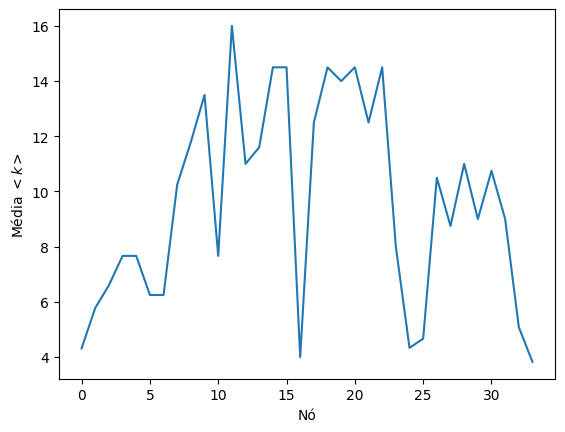

In [ ]:

G = nx.karate_club_graph()

print(f"Correlação: {nx.degree_pearson_correlation_coefficient(G)}")

G = nx.watts_strogatz_graph(8,4,0.1)

print(f"Correlação: {nx.degree_pearson_correlation_coefficient(G)}")

G = nx.Graph()

G.add_nodes_from([1, 2, 3, 4, 5])

for i in range(1, 6):
    for j in range(i+1, 6):
        G.add_edge(i, j)

G = nx.karate_club_graph()

u=np.array(list(nx.average_neighbor_degree(G).items())).T
plt.plot(u[:][0],u[:][1])
plt.ylabel('Média $<k>$')
plt.xlabel('Nó')
plt.show()


## Graus de bipartividade

Os graus de bipartividade medem a "bipartitividade" de um nó em um grafo bipartido. Em outras palavras, eles medem o quão bem conectado um nó de uma partição está com os nós da outra partição.

O cálculo dos graus de bipartividade pode ser útil para entender como os nós de diferentes partições estão conectados em um grafo bipartido e para identificar quais nós podem ser importantes para manter a conectividade entre as duas partições.

### Novo Grafo, Bipartido

In [ ]:
#gerando grafo bipartido
G = nx.Graph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E'], bipartite=0)
G.add_nodes_from([1, 2, 3, 4], bipartite=1)
G.add_edges_from([('A', 1), ('A', 2), ('B', 2), ('C', 2), ('C', 3), ('D', 3), ('D', 4), ('E', 4)])
canvas = jupyter_canvas()

canvas.nodes(G.nodes).add(color="orange")
canvas.edges(G.edges).add()

canvas

JupyterWidget(events=['{"attrs": {"nodes": {"A": {"color": "orange"}, "B": {"color": "orange"}, "C": {"color":…

## Centralidade de Subgrafo
Uma maneira de quantificar a centralidade de um vértice com base no número de subgrafos nos quais o vértice participa.A respectiva medida, chamada centralidade de subgrafo, considera o número de subgrafos que constituem um caminho fechado começando e terminando em um determinado vértice i, atribuindo pesos mais altos a subgrafos menores.

\begin{equation}
    SC=\sum_{j=1}^{N}e^{\lambda_{j}}
\end{equation}

 Sendo $\lambda_i$ os autovalores da matriz de adjacência. Essa medida está relacionada aos momentos da matriz de adjacência, que refletem as propriedades de conectividade do vértice na rede.

## Definição de grau de bipartividade

Abordagem utiliza a centralidade do subgrafo para calcular o grau de bipartição de uma rede. A centralidade do subgrafo é dividida entre caminhos fechados pares e ímpares, sendo que apenas os caminhos fechados pares são relevantes em redes bipartidas. Portanto, a fração da centralidade do subgrafo devido aos caminhos fechados pares pode ser usada como uma medida do grau de bipartição da rede.

\begin{equation}
    \beta=\frac{SC_{par}}{SC}=\frac{\sum_{j=1}^{N}cosh \lambda_{j}}{\sum_{j=1}^{N}e^{\lambda_{j}}}
\end{equation}

Onde SC é a centralidade do subgrafo da rede, $SC_{even}$ é a centralidade do subgrafo devido aos caminhos fechados pares e os $\lambda_j$ são os autovalores da matriz de adjacência da rede.

In [ ]:
# Criando um grafo bipartido
G = nx.Graph()
G.add_nodes_from(['A', 'B', 'C', 'D', 'E'], bipartite=0)
G.add_nodes_from([1, 2, 3, 4], bipartite=1)
G.add_edges_from([('A', 1), ('A', 2), ('B', 2), ('C', 2), ('C', 3), ('D', 3), ('D', 4), ('E', 4)])

bipartivity = nx.algorithms.bipartite.spectral_bipartivity(G)

print("Grau de bipartividade grafo bipartido")



print(f"{bipartivity}")

G = nx.karate_club_graph()

bipartivity = nx.algorithms.bipartite.spectral_bipartivity(G)

print("Grau de bipartividade Karater club")

print(f"{bipartivity}")


Grau de bipartividade grafo bipartido
1.0
Grau de bipartividade Karater club
0.5974141494528541


 ## informações de pesquisa, entropia de estrada e entropia de saida
 A estrutura de uma rede complexa afeta sua confiabilidade e velocidade de propagação de informações. A entropia de informação é usada para quantificar a dificuldade de buscar informações na rede. Relacionam a informação de busca com a localização de um alvo específico na rede. A informação média de busca caracteriza a facilidade ou dificuldade de navegação na rede, enquanto a informação de acesso mede a dificuldade de localizar vértices a partir de um vértice inicial.

 Seja p(i, b) um caminho mais curto que começa no vértice i e termina no vértice b. A probabilidade de seguir esse caminho em um passeio aleatório é

\begin{equation}
    P[p(i,b)]=\frac{1}{k_i}\prod_{j \in p(i,b)} \frac{1}{k_{j}-1}
\end{equation}

Onde $k_j$ é o grau do vértice j e o produto inclui todos os vértices j no caminho p(i, b) excluindo i e b.

A informação de busca, correspondente à informação total necessária para identificar um dos caminhos mais curtos entre i e b, é dada por

\begin{equation}
    S(i,b)=-log_{2}\sum_{p(i,b)}P[p(i,b)]
\end{equation}
onde a soma é feita sobre todos os caminhos mais curtos p(i, b) de i para b.

A informação média de busca caracteriza a facilidade ou dificuldade de navegação em uma rede dada por

\begin{equation}
    S=\frac{1}{N^2}\sum_{ib}S(i,b)
\end{equation}

 Informação de acesso:
\begin{equation}
    A_{i}=\frac{1}{N}\sum_{b}S(i,b)
\end{equation}

 Informação escondida:
 \begin{equation}
     A_{b}=\frac{1}{N}\sum_{i}S(i,b)
 \end{equation}



In [ ]:
def shortest_path_probability(G, i, b):
    paths = list(nx.all_shortest_paths(G, source=i, target=b))
    neighbors = list(G.neighbors(i))
    ki = len(neighbors)
    soma_prob=0
    for path in paths:
      probability = 1.0 / ki
      for j in path:
          neighbors = list(G.neighbors(j))
          k = len(neighbors)
          if j != b:
            probability *= 1.0 / (k - 1)
      soma_prob+=probability
    return soma_prob


In [ ]:
def entropy_A(G,i):
  S=0
  u=G.nodes()
  for j in u:
      S+=entropy(G,i,j)
  return  S/len(u)

In [ ]:
def entropy_H(G,i):
  S=0
  u=G.nodes()
  for j in u:
      S+=entropy(G,j,i)
  return  S/len(u)

In [ ]:
def entropy(G, i, b):
    return -math.log2(shortest_path_probability(G,i,b))


In [ ]:
def entropy_total(G):
  S=0
  u=G.nodes()
  for i in u:
    for j in u:
      S+=entropy(G,i,j)
  return S/len(u)**2


entropia total do sistema 3.4629397780267115



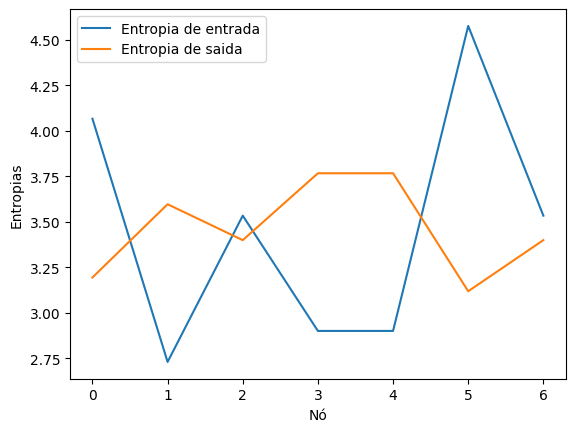

In [ ]:
G = nx.watts_strogatz_graph(7,4,0.4)
#G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4), (3, 5)])
matriz_entropy=np.empty((len(G.nodes()),len(G.nodes())))
print(f'entropia total do sistema {entropy_total(G)}\n')
E_A=[]
E_H=[]
#calculando a entropia da entrada e saida
for u in G.nodes():
  E_A.append(entropy_A(G,u))
  E_H.append(entropy_H(G,u))
u=G.nodes()
#plot do grafico
plt.plot(u,E_A,label='Entropia de entrada')
plt.plot(u,E_H,label='Entropia de saida')
plt.legend()
plt.ylabel('Entropias')
plt.xlabel('Nó')
plt.show()

## Espectro da matriz de adjacência

O espectro de uma rede corresponde ao conjunto de autovalores i de sua matriz de adjacência A. Temos a densidade de para rede será definido
\begin{equation}
    p(\lambda)=\frac{1}{N}\sum_{i}\delta(\lambda-\lambda_{i})
\end{equation}

Os autovalores e autovetores associados de uma rede estão relacionados ao diâmetro, ao número de ciclos e às propriedades de conectividade da rede.

Autovalores da matriz de adjacência:
1° momento 6.439293542825908e-16
2° momento 5.700000000000011
3° momento 6.300000000000062
4° momento 102.70000000000053


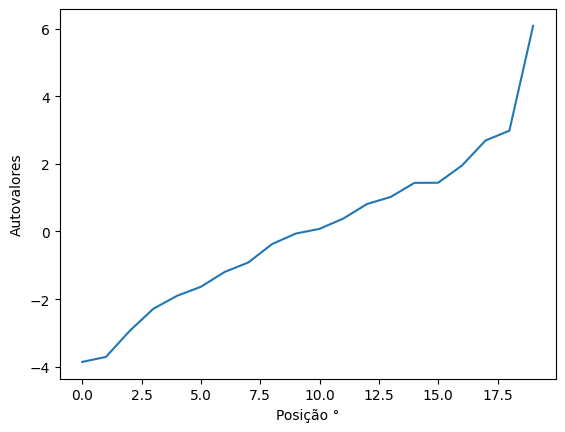

In [ ]:
G = nx.erdos_renyi_graph(20, 0.3)

adj_matrix = nx.to_numpy_array(G)

# Calculando os autovalores da matriz de adjacência
eigenvalues = np.linalg.eigvals(adj_matrix)

print("Autovalores da matriz de adjacência:")
plt.plot(range(len(eigenvalues)),sorted(eigenvalues))
plt.ylabel('Autovalores')
plt.xlabel('Posição °')

print(f'1° momento {np.sum(eigenvalues)/len(eigenvalues)}')
print(f'2° momento {np.sum(eigenvalues**2)/len(eigenvalues)}')
print(f'3° momento {np.sum(eigenvalues**3)/len(eigenvalues)}')
print(f'4° momento {np.sum(eigenvalues**4)/len(eigenvalues)}')
plt.show()



## Centralidade de intermediação

O método divisivo mais popular é o algoritmo de GirvanNewman. Como diferentes comunidades estão conectadas por um pequeno número de arestas, este método considera que os gargalos são formados nas arestas que conectam comunidades, por onde devem passar todos os caminhos mais curtos. Em ordem para medir essa propriedade relacionada ao tráfego nas redes, o algoritmo usa o conceito de limite intermediário.

In [ ]:
G = nx.karate_club_graph()

# Executa o algoritmo de Girvan-Newman
comp = girvan_newman(G)

communities = tuple(sorted(c) for c in next(comp))
print("Comunidades encontradas:")
print(communities)

#grafo bipartido
G = nx.Graph()
G.add_nodes_from([5, 6, 7, 8, 9], bipartite=0)
G.add_nodes_from([1, 2, 3, 4], bipartite=1)
G.add_edges_from([(5, 1), (5, 2), (6, 2), (7, 2), (7, 3), (8, 3), (8, 4), (9, 4)])

comp = girvan_newman(G)

communities = tuple(sorted(c) for c in next(comp))

print("Comunidades encontradas:")
print(communities)

Comunidades encontradas:
([0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
Comunidades encontradas:
([1, 2, 5, 6], [3, 4, 7, 8, 9])


## Maximização da modularidade

Newman propôs um método base em juntar as comunidades de tal forma que  modularidade(medida da estrutura de redes ou grafos que mede a força da divisão de uma rede em módulos) chegasse no máximo.

Temos que $e_{ij}$, uma matriz misturada de tamanho c x c onde é as quantidades de comunidades.

\begin{equation}
    \Delta Q_{ij} = 2 \left(e_{ij}-\frac{\sum_{j}e_{ij}\sum_{i}e_{ij}}{2M}\right)
\end{equation}

O metodo tenta procurar conectar as comunidades de tal forma que modularidade seja o máximo considerando todas as comunidade desconectada, temos que modularidade calcula normalizadamente.

\begin{equation}
    \frac{\Delta Q_{ij}}{\sum_{j}e_{ij}} = \frac{2}{\sum_{j}e_{ij}} (e_{ij}-\frac{\sum_{j}e_{ij}\sum_{i}e_{ij}}{2M})
\end{equation}







In [ ]:

G = nx.karate_club_graph()
c = nx.community.greedy_modularity_communities(G)
for i in sorted(c):
  print(i)
G = nx.Graph()

frozenset({8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})
frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21})
frozenset({0, 16, 19, 4, 5, 6, 10, 11})


## Metodo de seleção

Apesar dos muitos métodos alternativos interessantes, incluindo aqueles brevemente revisados acima, deve-se notar que o problema de encontrar comunidades continua sendo um desafio porque nenhum método único é rápido e sensível o suficiente para garantir resultados ideais para grandes redes gerais, um problema que é agravado pela falta de uma definição clara de comunidades. Se as comunidades devem ser identificadas com alta precisão, o método espectral proposto por Newman é uma boa escolha. No entanto, se a prioridade for atribuída à velocidade, métodos como os que usam algoritmos gulosos devem ser considerados. Em resumo, a escolha do melhor método a ser utilizado depende da configuração do problema e do tipo de resultado desejado. Um fato que deve ter ficado claro em nossa breve revisão das abordagens de localização de comunidades é a importância essencial da escolha das medidas adotadas para expressar a separação das comunidades. Na verdade, tais medições representam, em última análise, uma definição objetiva de comunidades. Portanto, uma perspectiva interessante para novas pesquisas seria considerar a possível adaptação e combinação de algumas das medições relatadas neste levantamento com o objetivo específico de caracterização da comunidade.

## Subgrafos e motivos em redes ponderadas

Em redes ponderadas, um subgrafo pode estar presente com valores diferentes para os pesos das arestas. Sugeriram uma definição para a intensidade de um subgrafo baseada na média geométrica de seus pesos na rede.
\begin{equation}
    I(g)=\left(\prod_{(i,j)\in \xi(g)}w_{ij}\right)^{1/n_{g}}
\end{equation}

onde $n_{g}=|\varepsilon(g)|$

Para caso os pesos sejam 1 ou pequeno demais, usamos coerência.

\begin{equation}
    \psi(g)=\frac{I_{g}n_{g}}{\sum_{(i,j)\in \xi(g)}w_{ij}}
\end{equation}


Onde usamos razão entre média geométrica e a aritmética.

In [ ]:

def I_g(G):
  w=nx.to_numpy_array(G)
  I=1
  for i in range(len(w[0])):
    for j in range(len(w)):
      if w[i][j]>0.0:
        I*=w[i][j]
  return I**(1/G.number_of_edges())

In [ ]:
def psi(G,I):
  a=nx.to_numpy_array(G)
  return  I*Aux.number_of_edges()/np.sum(a)

In [ ]:
G = nx.karate_club_graph()

Aux=G.subgraph([8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

I=I_g(Aux)

ps=psi(Aux,I)

print('Intensidade',I)

print('Coerencia',ps)



Aux=G.subgraph([0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21])

I=I_g(Aux)

ps=psi(Aux,I)

print('Intensidade',I)

print('Coerencia',ps)

canvas = jupyter_canvas()

canvas.nodes(Aux.nodes).add(color="orange")
canvas.edges(Aux.edges).add()

canvas

Intensidade 1.0
Coerencia 0.5
Intensidade 1.0
Coerencia 0.5


JupyterWidget(events=['{"attrs": {"nodes": {"0": {"color": "orange"}, "1": {"color": "orange"}, "3": {"color":…

## Coeficiente médio de agrupamento e coeficiente médio de agrupamento hierárquico de segundo nível.

O coeficiente de agrupamento mede a probabilidade de que os vizinhos dos vizinhos de um vértice em um grafo estejam conectados entre si.


 O coeficiente de agrupamento hierárquico de segundo nível é a média dessas médias para todos os vértices do grafo. Esse coeficiente é uma medida de como as conexões entre os vizinhos de um vértice se propagam para além do primeiro nível de vizinhos.

In [ ]:
def clustering_coefficient_2d(G):

    G1 = nx.Graph()
    for i in G.nodes():
        for j in G.neighbors(i):
            for k in G.neighbors(i):
                if j != k and j < k and k in G.neighbors(j):
                    G1.add_edge(j, k)
    N = len(G1.nodes())
    num = 0
    den = 0
    for i in G1.nodes():
        for j in G1.neighbors(i):
            for k in G1.neighbors(i):
                if j != k and j < k:
                    if G.has_edge(i, j) and G.has_edge(i, k) and G.has_edge(j, k):
                        num += 1
                    if G.has_edge(i, j) and G.has_edge(i, k):
                        den += 1

    if den == 0:
        return 0
    else:
        return (1/N) * (num / den)


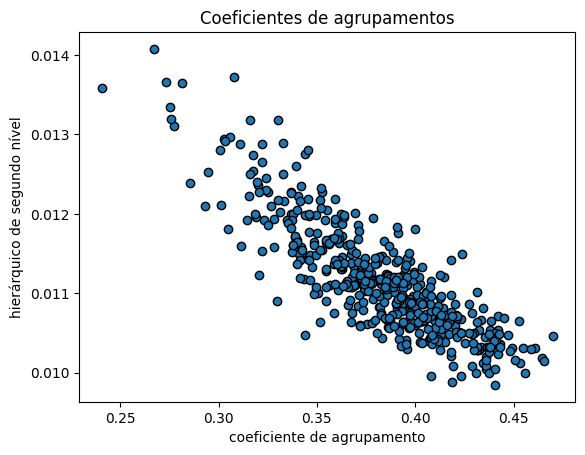

In [ ]:
avg_clu=[]
clu_2d=[]
for i in range(500):
  G = nx.watts_strogatz_graph(50,5,0.1)

  clustering_coefficients = nx.clustering(G)
  avg_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)

  avg_clu.append(avg_clustering_coefficient)
  clu_2d.append(clustering_coefficient_2d(G))
#plot da relação entres os dois coeficientes
plt.scatter(avg_clu,clu_2d,edgecolor='black')
plt.title('Coeficientes de agrupamentos')
plt.xlabel('coeficiente de agrupamento')
plt.ylabel('hierárquico de segundo nível')
plt.show()

## Análise de Variáveis Canônicas

É uma técnica de análise de regressão que envolve a criação de novas variáveis, conhecidas como variáveis canônicas, sendo combinações lineares das variáveis originais. A ideia é criar novas variáveis que capturem a maior quantidade possível de variação nas variáveis originais e que estejam altamente correlacionadas entre si.

Para fazer essas transformações, devemos definir a **matriz de dispersão**.
\begin{equation}
    S_{i}=\sum_{\xi \in C_{i}}(\vec{X_{\xi}}-<\vec{X}>_{i})(\vec{X_{\xi}}-<\vec{X}>_{i})^{T}
\end{equation}

Assim podemos definir duas, primeira a matriz **matriz de dispersão de interclasse**

\begin{equation}
    S_{intra}=\sum_{i=1}^{N_{c}} S_{i}
\end{equation}


e a matriz de disperção interclaase

\begin{equation}
    S_{inter}=\sum_{i=1}N_{i}(<\vec{X}>_{i}-<\vec{X}>)(<\vec{X}>_{i}-<\vec{X}>)^{T}
\end{equation}

Para encontrar os autovetores que irão fazer transmação do CVA, encontrando os autovetores da matriz $S_{intra}^{-1}S_{inter}$.


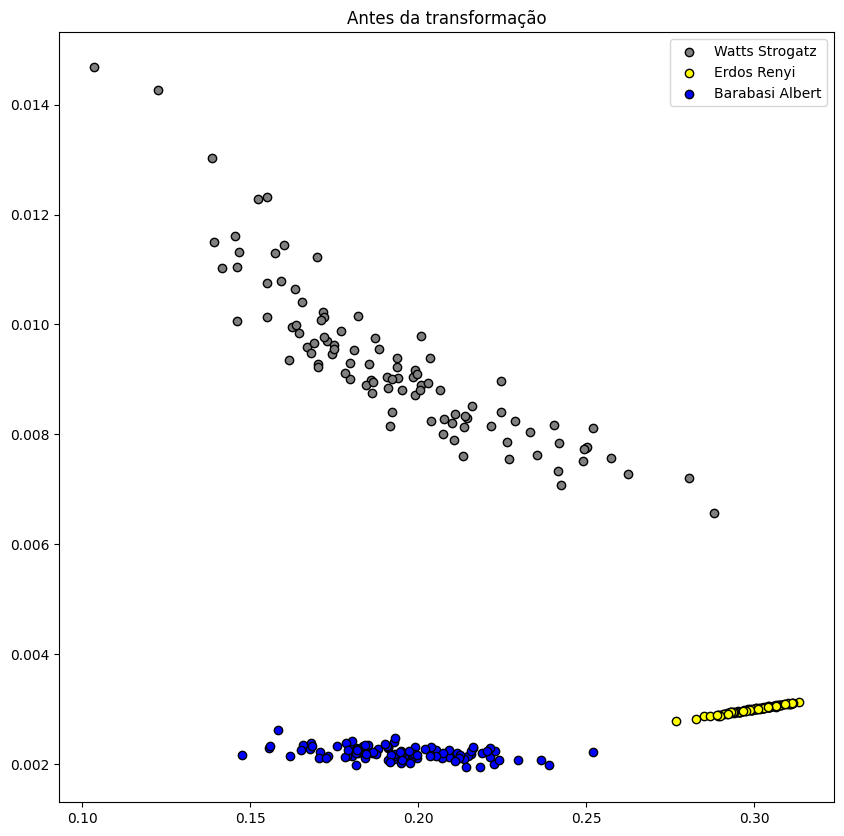

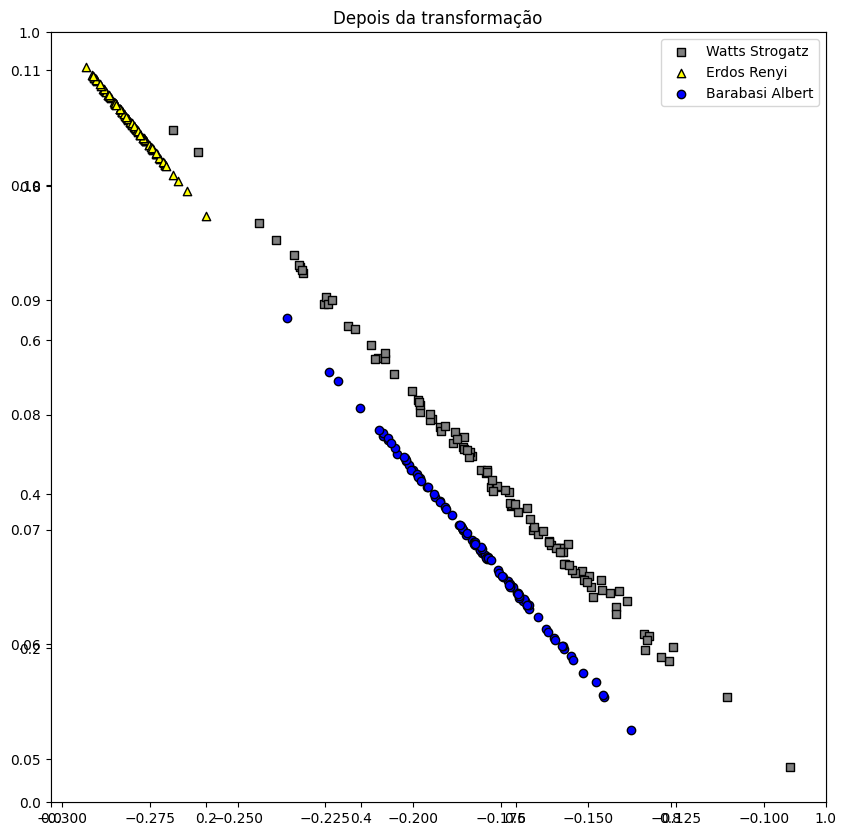

In [ ]:
import numpy as np
from matplotlib import style
n=100

x1=[]
y1=[]
x2=[]
y2=[]
x3=[]
y3=[]
classes=[]

for i in range(n):
  # grafos
  Sw=nx.watts_strogatz_graph(100,5,0.3)
  Er=nx.erdos_renyi_graph(100,0.3)
  Ba=nx.barabasi_albert_graph(100,5)
  # grafos Watts Strogatz
  clustering_coefficients = nx.clustering(Sw)
  avg_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)
  x1.append(avg_clustering_coefficient)
  y1.append(clustering_coefficient_2d(Sw))
  classes.append(0)
  # grafos Er
  clustering_coefficients = nx.clustering(Er)
  avg_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)
  x2.append(avg_clustering_coefficient)
  y2.append(clustering_coefficient_2d(Er))
  classes.append(1)
  # grafos Ba
  clustering_coefficients = nx.clustering(Ba)
  avg_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)
  x3.append(avg_clustering_coefficient)
  y3.append(clustering_coefficient_2d(Ba))
  classes.append(2)

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
plt.title("Antes da transformação")
ax0.scatter(x1,y1,label='Watts Strogatz',c='grey',edgecolor='black')
ax0.scatter(x2,y2,label='Erdos Renyi',c='yellow',edgecolor='black')
ax0.scatter(x3,y3,label='Barabasi Albert',c='blue',edgecolor='black')
ax0.legend()
plt.show()

# Calculate the mean vectors per class
z1=[x1,y1]
z2=[x2,y2]
z3=[x3,y3]

d=2
mena=np.array([x1+x2+x3,y1+y2+y3])
mean_overall = np.mean(mena, axis=1)
S_B = np.zeros((d, d))

mean_rectangles = np.mean(z1,axis=1).reshape(2,1) # Creates a 2x1 vector consisting of the means of the dimensions
mean_triangles = np.mean(z2,axis=1).reshape(2,1)
mean_circles = np.mean(z3,axis=1).reshape(2,1)

mean_vec=[mean_rectangles,mean_triangles,mean_circles ]

for i, mean_vec in enumerate(mean_vec):
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)



mean_rectangles = np.mean(z1,axis=1).reshape(2,1) # Creates a 2x1 vector consisting of the means of the dimensions
mean_triangles = np.mean(z2,axis=1).reshape(2,1)
mean_circles = np.mean(z3,axis=1).reshape(2,1)

# Calculate the scatter matrices for the SW (Scatter within) and sum the elements up

scatter_rectangles = np.dot((z1-mean_rectangles),(z1-mean_rectangles).T)
scatter_triangles = np.dot((z2-mean_triangles),(z2-mean_triangles).T)
scatter_circles = np.dot((z3-mean_circles),(z3-mean_circles).T)

# Calculate the SW by adding the scatters within classes
SW = scatter_triangles+scatter_circles+scatter_rectangles

eigen_vals, eigen_vecs = np.linalg.eigh(np.linalg.inv(SW).dot(S_B))

z1_trans = np.dot(eigen_vecs,np.array(z1))
z2_trans = np.dot(eigen_vecs,np.array(z2))
z3_trans = np.dot(eigen_vecs,np.array(z3))


fig = plt.figure(figsize=(10,10))
plt.title("Depois da transformação")
ax0 = fig.add_subplot(111)
ax0.scatter(z1_trans[0],z1_trans[1],marker='s',label='Watts Strogatz',c='grey',edgecolor='black')
ax0.scatter(z2_trans[0],z2_trans[1],marker='^',label='Erdos Renyi',c='yellow',edgecolor='black')
ax0.scatter(z3_trans[0],z3_trans[1],marker='o',label='Barabasi Albert',c='blue',edgecolor='black')
ax0.legend()
plt.show()




## Grau hierárquico médio de segundo nível

Também conhecido como HD2, é uma medida de centralidade em redes que tenta capturar a importância dos nós em diferentes níveis hierárquicos na rede

In [ ]:
def HDR2(G):
  hd2 = {}
  for node in G.nodes():
      hd2[node] = sum([G.degree(neighbor) for neighbor in G.neighbors(node)]) - 2 * G.degree(node)
  mean=0
  for node, value in hd2.items():
      mean+=value
  return mean/len(hd2.items())

## Razão de divergência hierárquica média do terceiro nível

Medida de centralidade em grafos que considera a diversidade dos caminhos mais curtos que passam por um nó.





In [ ]:
def HDR3(G):
  root = max(dict(G.degree()).items(), key=lambda x: x[1])[0]
  shortest_paths = nx.single_source_shortest_path(G, root)
  predecessors = {}
  for node in G.nodes():
      pred = []
      for path in shortest_paths.values():
          if node in path and path.index(node) > 0:
              pred.append(path[path.index(node)-1])
      predecessors[node] = pred
  hdr3 = {}
  for node in G.nodes():
      hdr = 1
      for pred in predecessors[node]:
          hdr *= nx.degree(G, pred)
      hdr3[node] = hdr
  mean = 0
  for node, hdr in hdr3.items():
      mean+=hdr
  return mean/len(hdr3.items())



## Análise do componente principal

O objetivo é encontrar um conjunto menor de variáveis, chamados componentes principais, que resumem as informações contidas no conjunto original de variáveis.

Para calcular temos
\begin{equation}
    K=\frac{(\vec{x}-<\vec{x}>)(\vec{x}-<\vec{x}>)^T}{R}
\end{equation}

O K será um matriz simétrica e real, portanto, será do tamanho P é tamanho das métricas, assim teremos P autovalores distitos $\lambda_I$, portanto temos que os serão distintos autovetores. Podemos construir a seguinte matriz de transformação

\begin{equation}
    T=(1,1,1,..,1,1)^T\otimes[v_{1},v_{2},v_{3},...,v_{p-1},v_{p}]
\end{equation}

Onde podemos definir a **Projeção das componentes principais**





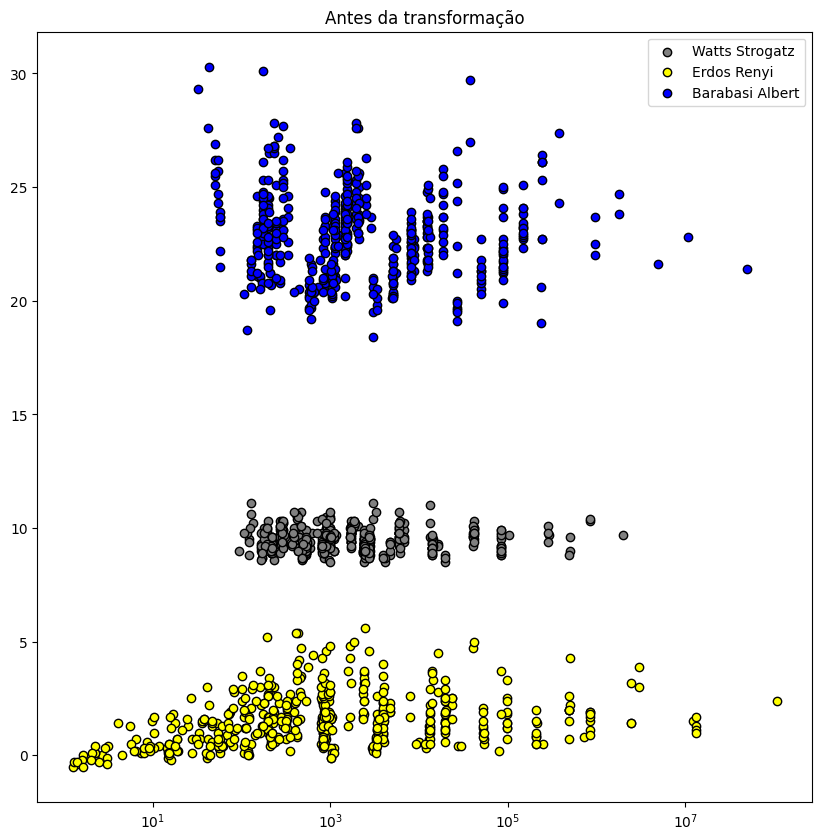

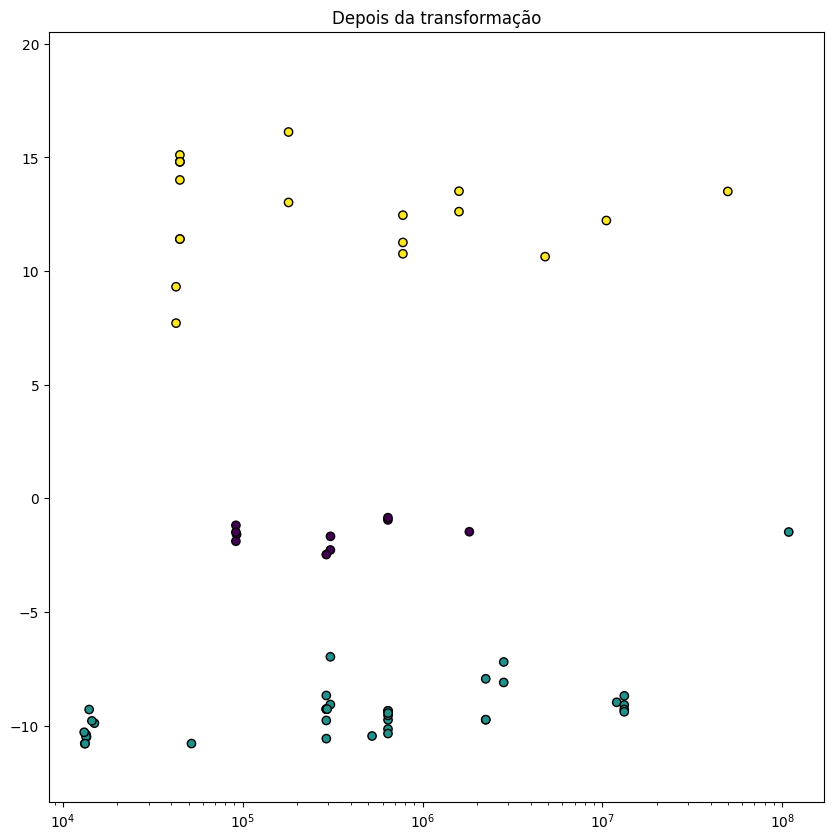

In [ ]:
x1=[]
y1=[]
x2=[]
y2=[]
x3=[]
y3=[]
classes=[]

for i in range(500):
  G = nx.watts_strogatz_graph(20,5,0.5)
  Er=nx.erdos_renyi_graph(20,0.1)
  Ba=nx.barabasi_albert_graph(20,3)
  classes.append(0)
  x1.append(HDR3(G))
  y1.append(HDR2(G))
  classes.append(1)
  x2.append(HDR3(Er))
  y2.append(HDR2(Er))
  classes.append(2)
  x3.append(HDR3(Ba))
  y3.append(HDR2(Ba))

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
plt.title("Antes da transformação")
ax0.scatter(x1,y1,label='Watts Strogatz',c='grey',edgecolor='black')
ax0.scatter(x2,y2,label='Erdos Renyi',c='yellow',edgecolor='black')
ax0.scatter(x3,y3,label='Barabasi Albert',c='blue',edgecolor='black')
plt.xscale('log')
ax0.legend()
plt.show()

data=list(zip(x1+x2+x3,y1+y2+y3))
pca = PCA(n_components=2)
components = pca.fit_transform(data)
classes2=[0]*len(x1)+[1]*len(x2)+[2]*len(x3)
# Plota os componentes principais
fig = plt.figure(figsize=(10,10))
plt.title("Depois da transformação")
plt.scatter(components[:,0], components[:,1],c=classes2,edgecolor='black')
plt.xscale('log')
plt.show()


## Reciprocidade de borda

Essas informações ajudam a obter uma melhor caracterização da rede, podem ser usadas para testar modelos de rede em relação a redes reais e dão indicação de quanta informação é perdida quando a direção das arestas é descartada (por exemplo, para o cálculo de algumas medições que só se aplicam para redes não direcionadas).

$𝘱=\frac{\sum_{ij}a_{ij}a_{ji}}{M}$

Temos que **Reciprocidade de borda**, onde $<a>$ é media da matriz adjacência

$ɖ=\frac{p-<a>}{1-<a>}$

Onde $ɖ$ é maior que zero implica em reciprocidade.

In [ ]:
def edges_rec(G):
  num_reciprocal_edges = 0
  num_edges = G.number_of_edges()
  for u, v in G.edges():
      if G.has_edge(v, u):
          num_reciprocal_edges += 1

  return num_reciprocal_edges / num_edges

In [ ]:
def edges_coef(G):
  matrix=nx.to_numpy_array(G)
  a=matrix.mean()
  return (edges_rec(G)-a)/(1-a)

In [ ]:

G = nx.DiGraph()
G.add_edges_from([(1,2), (2,3), (3,1), (1,4), (4,1)])

print("Grafo aleatório Reciprocidade de borda: {:.2f}".format(edges_coef(G)))

G = nx.watts_strogatz_graph(20,4,0.1)

print("Watts Strogatz Reciprocidade de borda: {:.2f}".format(edges_coef(G)))

Grafo aleatório Reciprocidade de borda: 0.13
Watts Strogatz Reciprocidade de borda: 1.00


## A análise de correlação

Embora um número virtualmente infinito de medições possa ser obtido para quantificar a conectividade de redes complexas, um grau variável de redundância será observado entre suas combinações de pares. Por exemplo, o grau do nó e o coeficiente de agrupamento não são correlacionados para a maioria das redes. Além disso, a intensidade de tais correlações pode depender do tipo específico de rede complexa. No presente trabalho quantificamos o grau de correlação entre duas medidas x e y em um conjunto de n redes, entendidas como duas variáveis aleatórias, em termos do coeficiente de correlação de Pearson.

In [ ]:
G = nx.karate_club_graph()
#duas métricas diferentes
deg_centrality = nx.degree_centrality(G)
btw_centrality = nx.betweenness_centrality(G)

deg_centrality_vec = np.array(list(deg_centrality.values()))
btw_centrality_vec = np.array(list(btw_centrality.values()))
#Correlação
corr_coef = np.corrcoef(deg_centrality_vec, btw_centrality_vec)[0,1]
print("Coeficiente de correlação: {:.2f}".format(corr_coef))


Coeficiente de correlação: 0.91


## Bayesiano

 A metodologia elegante e sólida conhecida como teoria da decisão bayesiana fornece um meio intuitivo e eficaz para classificar objetos em um determinado conjunto de categorias. Em princípio, assume-se que as probabilidades de massa $P_i$, bem como as condicionais densidades de probabilidade, $p(\vec{x}_{ϵ}|C_{i})$ ou podem ser estimados adequadamente. A probabilidade em massa $P_i$ corresponde à probabilidade de um objeto, independentemente de suas propriedades, pertencer à classe $C_i$ e, portanto, pode ser estimado a partir da respectiva frequência relativa. A probabilidades condicionais $p(\vec{x}_{ϵ}|C_{i})$ fornecem um modelo estatístico de como as medidas nos vetores de características são distribuídas dentro de cada categoria.

Caso as funções de probabilidade não estejam disponíveis, ainda é possível usar métodos de classificação aproximados como k-vizinhos mais próximos, que consiste em identificar o conjunto dos k indivíduos que estão mais próximos à amostra a ser classificada, e toma como categoria resultante aquela que corresponde à classe mais frequente entre os vizinhos mais próximos.

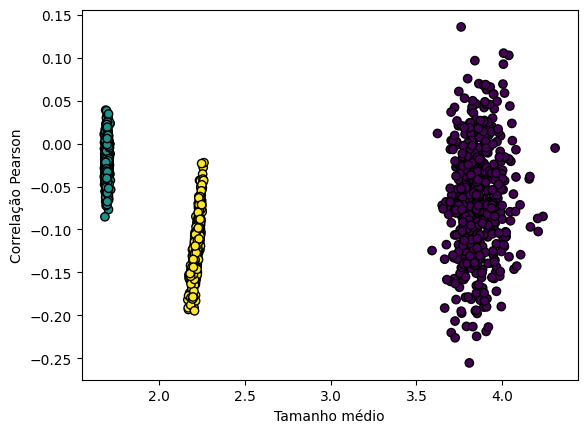

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#criando a lista
x=[]
y=[]
classes=[]
for i in range(500):
  Sw=nx.watts_strogatz_graph(100,5,0.3)
  Er=nx.erdos_renyi_graph(100,0.3)
  Ba=nx.barabasi_albert_graph(100,5)
  # grafos Sw
  x.append(nx.average_shortest_path_length(Sw))
  y.append(nx.degree_pearson_correlation_coefficient(Sw))
  classes.append(0)
  # grafos Er
  x.append(nx.average_shortest_path_length(Er))
  y.append(nx.degree_pearson_correlation_coefficient(Er))
  classes.append(1)
  # grafos Ba
  x.append(nx.average_shortest_path_length(Ba))
  y.append(nx.degree_pearson_correlation_coefficient(Ba))
  classes.append(2)

knn = KNeighborsClassifier(n_neighbors=10)
data = list(zip(x,y))
knn.fit(data,classes)
plt.xlabel("Tamanho médio")
plt.ylabel("Correlação Pearson")
plt.scatter(x,y,c=classes,edgecolor='black')
plt.show()

# Caminhada Deterministica

## Entropia de Shannon
A entropia de Shannon (ES) é usada como uma medida para a assimetria entre zeros e uns na série temporal de cada nó e, quando calculada em média para todos os nós, dos padrões "espácio temporais". Para obter a entropia de Shannon do padrão, calculamos a entropia de Shannon para cada nó e depois fazemos a média para todos os N nós:
\begin{equation}
    E_{s}=\frac{-1}{N}\sum_{i=0}^{N}p_{i}^{0}\log(p_{i}^{0})+p_{i}^{1}\log(p_{i}^{1})
\end{equation}
onde $p_{i}^{0}$ e $p_{i}^{1}$ são estimadas a partir das proporções de 0 e 1 na série temporal do nó i.

## Entropia de palavras

A entropia de palavras quantifica a irregularidade de uma série temporal em uma escala maior (tempo), contando o número de palavras constantes (ou seja, blocos de estados constantes delimitados pelo respectivo outro estado binário):

\begin{equation}
    E_{w}=\frac{-1}{N}\sum_{i=0}^{N}\sum_{l=0}^{\infty}p_{i}^{l}\log(p_{i}^{l})
\end{equation}

A probabilidade $p_{i}^{l}$ é calculada dividindo o número de palavras constantes de comprimento l pelo número total de palavras encontradas na série temporal do nó i.

In [ ]:
def shannon(G):
  soma=0
  le=len(list(G.nodes()))
  for node in G.nodes():
      soma+=G.nodes[node]['state']
  prob=soma/le
  if prob>0 and 1>prob:
    return (-1)*(prob*np.log(prob)+(1-prob)*np.log(1-prob))
  return 0

In [ ]:
def Ew(G):
  lst=[G.nodes[i]['state'] for i in G.nodes()]
  sequence_lengths=count_sequence_lengths(lst)
  l=len(sequence_lengths)
  entropy=0.0
  for i in range(max(sequence_lengths)+1):#fazendo todas as probabilidades
    soma=0
    for j in sequence_lengths:#
      if i==j:
        soma+=1
    prob=soma/l
    if prob>0:#probabilidade
      entropy+= prob*np.log(prob)
  return -entropy

def count_sequence_lengths(lst):
    sequence_lengths = []#criando variaveis iniciais
    current_length = 0
    current_value = None

    for value in lst:#contagem dos tamanhos
        if value != current_value:
            if current_value is not None:#caso a lista não exista
                sequence_lengths.append(current_length)
            current_value = value
            current_length = 1
        else:
            current_length += 1

    if current_value is not None:#inserindo
        sequence_lengths.append(current_length)

    return sequence_lengths



## Spatio-temporal
Os autômatos celulares têm sido amplamente utilizados em diversos estudos para investigar como padrões complexos surgem a partir de regras dinâmicas simples.

\begin{equation}
x_{i}(t+1)=\left\{\begin{array}{c}
        \alpha \text{,    }  p_i\geq k\\
        \beta \text{,   }   p_i<k \\
    \end{array}\right\}
\end{equation}

temos que $\alpha,\beta \in \{1,0,"+","-"\}$, onde $+=x_{i}(t)$ e $-=x_{i}(t)$.

In [ ]:
law=33#regras
#valores que deram certo
#182
#descartado
#123,174
k=0.5
run=50

In [ ]:
def apply_rule(graph,r,k):
    new_graph = graph.copy()


    for node in graph.nodes():

        soma=0
        len0=len(list(graph.neighbors(node)))
        if len0>0:
          for j in graph.neighbors(node):
            soma+=graph.nodes[j]['state']
          prob=soma/len0
        else:
          prob=0
        if (r[7] == 1 and prob>=k):#regra 128
            new_graph.nodes[node]['state'] = 1
        elif (r[6] == 1 and prob>=k):#regra 64
            new_graph.nodes[node]['state'] = 0
        elif (r[5] == 1 and prob>=k):#regra 32
            new_graph.nodes[node]['state'] = 1-graph.nodes[node]['state']
        elif (r[4] == 1 and prob>=k):#regra 16
            new_graph.nodes[node]['state'] = graph.nodes[node]['state']
        elif (r[3] == 1 and prob<k):#regra 8
            new_graph.nodes[node]['state'] = 1
        elif (r[2] == 1 and prob<k):#regra 4
            new_graph.nodes[node]['state'] = 0
        elif (r[1] == 1 and prob>=k):#regra 2
            new_graph.nodes[node]['state'] = 1-graph.nodes[node]['state']
        elif (r[0] == 1 and prob<k):#regra 1
            new_graph.nodes[node]['state'] = graph.nodes[node]['state']
    return new_graph

def run_simulation(initial_graph, num_steps, number_rule,k):
    rule = format(number_rule, '08b')#colocando no formato dos 8 bits
    list_rule = [int(bit) for bit in rule]
    graphs = [initial_graph]
    for _ in range(num_steps):
        new_graph = apply_rule(graphs[-1],list_rule[-1::-1],k)
        graphs.append(new_graph)
    return graphs




### Entropy word

In [ ]:
import os
Ew_Bar=[]
Path = "/content/drive/MyDrive/csv/T4/Barabasi/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation(G, run, law,k)
          ews=[]
          for graph in graphs:
            ews.append(Ew(graph))
          Ew_Bar.append(np.mean(ews))


In [ ]:
import os
Ew_Er=[]
Path = "/content/drive/MyDrive/csv/T4/Erdos/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation(G, run, law,k)
          ews=[]
          for graph in graphs:
            ews.append(Ew(graph))
          Ew_Er.append(np.mean(ews))

In [ ]:
import os
Ew_Ge=[]
Path = "/content/drive/MyDrive/csv/T4/Geo/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation(G, run, law,k)
          ews=[]
          for graph in graphs:
            ews.append(Ew(graph))
          Ew_Ge.append(np.mean(ews))

In [ ]:
import os
Ew_Wa=[]
Path = "/content/drive/MyDrive/csv/T4/Watts/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation(G, run, law,k)
          ews=[]
          for graph in graphs:
            ews.append(Ew(graph))
          Ew_Wa.append(np.mean(ews))

### Shannon entropy

In [ ]:
import os
shannon_Bar=[]
Path = "/content/drive/MyDrive/csv/T4/Barabasi/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation(G, run, law,k)
          ews=[]
          for graph in graphs:
            ews.append(shannon(graph))
          shannon_Bar.append(np.mean(ews))


In [ ]:
import os
shannon_Er=[]
Path = "/content/drive/MyDrive/csv/T4/Erdos/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation(G, run, law,k)
          ews=[]
          for graph in graphs:
            ews.append(shannon(graph))
          shannon_Er.append(np.mean(ews))

In [ ]:
import os
shannon_Ge=[]
Path = "/content/drive/MyDrive/csv/T4/Geo/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation(G, run, law,k)
          ews=[]
          for graph in graphs:
            ews.append(shannon(graph))
          shannon_Ge.append(np.mean(ews))

In [ ]:
import os
shannon_Wa=[]
Path = "/content/drive/MyDrive/csv/T4/Watts/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation(G, run, law,k)
          ews=[]
          for graph in graphs:
            ews.append(shannon(graph))
          shannon_Wa.append(np.mean(ews))

In [ ]:
l=125
color=[1]*l+[2]*l+[3]*l+[4]*l
classes=['Er']*l+['Bar']*l+['Geo']*l+['Wat']*l
df=pd.DataFrame({"Color":color
                ,"Classes":classes
                ,"Shannon":shannon_Er+shannon_Bar+shannon_Ge+shannon_Wa
                ,"Ew":Ew_Er+Ew_Bar+Ew_Ge+Ew_Wa})

## Conclusão
Para a rede Barabasi e geometrica podemos distinguir através de um scatter plot usando a regra 33.

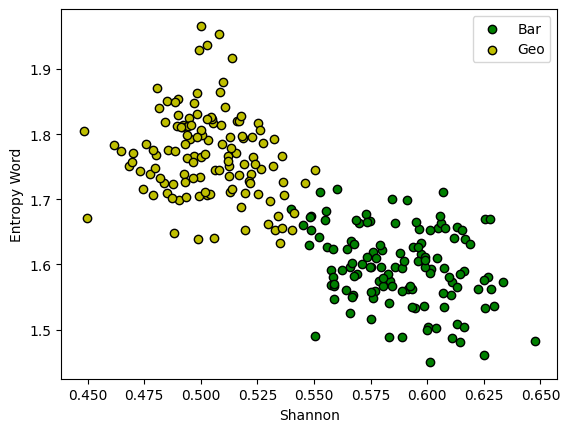

In [ ]:
l=125
#plt.scatter(df["Shannon"][:l],df["Ew"][:l],c='r',label=df["Classes"][0],edgecolor='black')
plt.scatter(df["Shannon"][l:2*l],df["Ew"][l:2*l],c='g',label=df["Classes"][l],edgecolor='black')
plt.scatter(df["Shannon"][2*l:3*l],df["Ew"][2*l:3*l],c='y',label=df["Classes"][2*l],edgecolor='black')
#plt.scatter(df["Shannon"][3*l:4*l],df["Ew"][3*l:4*l],c='k',label=df["Classes"][3*l])
plt.xlabel("Shannon")
plt.ylabel("Entropy Word")
plt.legend()
plt.show()

## LLNA

https://scg.ifsc.usp.br/llna/#

O Autômato de Rede Vida-Semelhante\cite{miranda2016exploring} (LLNA em inglês) foi criado para reconhecer padrões em redes. Ele utiliza a topologia da rede para formar uma malha em um Autômato Celular (CA), cuja dinâmica produz um padrão espacial e temporal utilizado para extrair atributos e características da rede. O CA implementado é baseado nas regras do Vida-Semelhante.

É importante observar que, devido às diferentes dimensões dos vizinhos em comparação com reticulados 1D ou 2D regulares, e à falta de uma ordem específica entre os vizinhos, apenas um conjunto limitado de regras clássicas de autômatos celulares pode ser plausivelmente aplicado a grafos gerais. Portanto, concentramos nossa atenção nos autômatos celulares totalitarísticos, nos quais apenas um autômato celular onde o estado de um nó i é determinado pela densidade dos estados em seus vizinhos. Implementamos uma dinâmica de limiar em que um nó altera seu estado se a densidade de estados em seu entorno ultrapassar um determinado limiar. Caso contrário, o nó mantém seu estado atual.

\begin{equation}
x_{i}(t+1)=\left\{
    \begin{array}{c}
        1, \frac{x}{9}\leq p_i<\frac{x+1}{9},\text{se } x\neq8 \\
        1, \frac{x}{9}\leq p_i\leq\frac{x+1}{9},\text{se } x=8      \\
        0,\text{Outros casos}
    \end{array}\right\}
\end{equation}


In [ ]:
def apply_rule_LLNA(graph,b,s):
    new_graph = graph.copy()

    for node in graph.nodes():
        soma=0
        len0=len(list(graph.neighbors(node)))
        if len0>0:
          for j in graph.neighbors(node):
            soma+=graph.nodes[j]['state']#somando todos
          prob=soma/len0#fazendo a probabilidade
        else:
          prob=0
        if ((b[8] == 1 and graph.nodes[node]['state']==1) or (s[8] == 1 and graph.nodes[node]['state']==0) and prob>=8/9):
            new_graph.nodes[node]['state'] = 1#regra B8 ou S8
        elif ((b[7] == 1 and graph.nodes[node]['state']==1) or (s[7] == 1 and graph.nodes[node]['state']==0) and prob>=7/9):
            new_graph.nodes[node]['state'] = 1#regra B7 ou S7
        elif ((b[6] == 1 and graph.nodes[node]['state']==1) or (s[6] == 1 and graph.nodes[node]['state']==0) and prob>=6/9):
            new_graph.nodes[node]['state'] = 1#regra B6 ou S6
        elif ((b[5] == 1 and graph.nodes[node]['state']==1) or (s[5] == 1 and graph.nodes[node]['state']==0) and prob>=5/9):
            new_graph.nodes[node]['state'] = 1#regra B5 ou S5
        elif ((b[4] == 1 and graph.nodes[node]['state']==1) or (s[4] == 1 and graph.nodes[node]['state']==0) and prob>=4/9):
            new_graph.nodes[node]['state'] = 1#regra B4 ou S4
        elif ((b[3] == 1 and graph.nodes[node]['state']==1) or (s[3] == 1 and graph.nodes[node]['state']==0) and prob>=3/9):
            new_graph.nodes[node]['state'] = 1#regra B3 ou S3
        elif ((b[2] == 1 and graph.nodes[node]['state']==1) or (s[2] == 1 and graph.nodes[node]['state']==0) and prob>=2/9):
            new_graph.nodes[node]['state'] = 1#regra B2 ou S2
        elif ((b[1] == 1 and graph.nodes[node]['state']==1) or (s[1] == 1 and graph.nodes[node]['state']==0) and prob>=1/9):
            new_graph.nodes[node]['state'] = 1#regra B1 ou S1
        elif ((b[0] == 1 and graph.nodes[node]['state']==1) or (s[0] == 1 and graph.nodes[node]['state']==0) and prob>=0):
            new_graph.nodes[node]['state'] = 1#regra B0 ou S0
        else:
            new_graph.nodes[node]['state'] = 0#outros casos
    return new_graph

def run_simulation_LLNA(initial_graph, num_steps, number_rul1,number_rul2):
    rule = format(number_rul1, '09b')
    list_rule1 = [int(bit) for bit in rule]
    rule = format(number_rul2, '09b')
    list_rule2 = [int(bit) for bit in rule]
    graphs = [initial_graph]
    for _ in range(num_steps):
        new_graph = apply_rule_LLNA(graphs[-1],list_rule1[-1::-1],list_rule2[-1::-1])
        graphs.append(new_graph)
    return graphs

In [ ]:
law1=163#regras para o B
law2=176#regras para o S
#B8610/S865
k=0.5#divisor
run=50#quantidades de iterações

### Entropy Word

In [ ]:
import os
Ew_Bar=[]
Path = "/content/drive/MyDrive/csv/T4/Barabasi/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation_LLNA(G, run, law1,law2)
          ews=[]
          for graph in graphs:
            ews.append(Ew(graph))
          Ew_Bar.append(np.mean(ews))


In [ ]:
import os
Ew_Er=[]
Path = "/content/drive/MyDrive/csv/T4/Erdos/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation_LLNA(G, run, law1,law2)
          ews=[]
          for graph in graphs:
            ews.append(Ew(graph))
          Ew_Er.append(np.mean(ews))

In [ ]:
import os
Ew_Ge=[]
Path = "/content/drive/MyDrive/csv/T4/Geo/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation_LLNA(G, run, law1,law2)
          ews=[]
          for graph in graphs:
            ews.append(Ew(graph))
          Ew_Ge.append(np.mean(ews))

In [ ]:
import os
Ew_Wa=[]
Path = "/content/drive/MyDrive/csv/T4/Watts/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation_LLNA(G, run, law1,law2)
          ews=[]
          for graph in graphs:
            ews.append(Ew(graph))
          Ew_Wa.append(np.mean(ews))

### Shannon Entropy

In [ ]:
import os
shannon_Bar=[]
Path = "/content/drive/MyDrive/csv/T4/Barabasi/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation_LLNA(G, run, law1,law2)
          ews=[]
          for graph in graphs:
            ews.append(shannon(graph))
          shannon_Bar.append(np.mean(ews))


In [ ]:
import os
shannon_Er=[]
Path = "/content/drive/MyDrive/csv/T4/Erdos/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation_LLNA(G, run, law1,law2)
          ews=[]
          for graph in graphs:
            ews.append(shannon(graph))
          shannon_Er.append(np.mean(ews))

In [ ]:
import os
shannon_Ge=[]
Path = "/content/drive/MyDrive/csv/T4/Geo/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation_LLNA(G, run, law1,law2)
          ews=[]
          for graph in graphs:
            ews.append(shannon(graph))
          shannon_Ge.append(np.mean(ews))

In [ ]:
import os
shannon_Wa=[]
Path = "/content/drive/MyDrive/csv/T4/Watts/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          attrs={}
          for i in G.nodes():#dando peso para os nós
            attrs[i] = {"state": int(2*random.random())}
          nx.set_node_attributes(G, attrs)
          graphs = run_simulation_LLNA(G, run, law1,law2)
          ews=[]
          for graph in graphs:
            ews.append(shannon(graph))
          shannon_Wa.append(np.mean(ews))

In [ ]:
l=125
color=[1]*l+[2]*l+[3]*l+[4]*l
classes=['Er']*l+['Bar']*l+['Geo']*l+['Wat']*l
df=pd.DataFrame({"Color":color
                ,"Classes":classes
                ,"Shannon":shannon_Er+shannon_Bar+shannon_Ge+shannon_Wa
                ,"Ew":Ew_Er+Ew_Bar+Ew_Ge+Ew_Wa})

## Conclusão

Podemos distinguir parcialmente Erdos e Barabasi, usando a regra

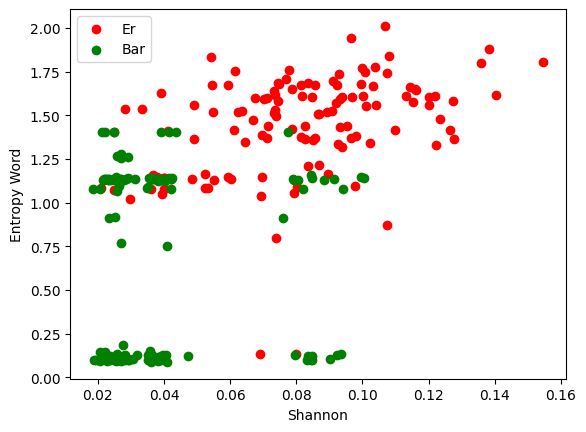

In [ ]:
l=125
plt.scatter(df["Shannon"][:l],df["Ew"][:l],c='r',label=df["Classes"][0])
plt.scatter(df["Shannon"][l:2*l],df["Ew"][l:2*l],c='g',label=df["Classes"][l])
#plt.scatter(df["Shannon"][2*l:3*l],df["Ew"][2*l:3*l],c='y',label=df["Classes"][2*l])
#plt.scatter(df["Shannon"][3*l:4*l],df["Ew"][3*l:4*l],c='k',label=df["Classes"][3*l])
plt.xlabel("Shannon")
plt.ylabel("Entropy Word")
plt.legend()
plt.show()

# Caminhada Aleatória


In [ ]:
class WalkSCAN:

    def __init__(self, nb_steps=2, eps=0.1, min_samples=3):
        self.nb_steps = nb_steps
        self.eps = eps
        self.min_samples = min_samples
        self.dbscan_ = DBSCAN(eps=self.eps, min_samples=self.min_samples)

    def load(self, graph, init_vector):
        self.graph = graph.copy()
        self.init_vector = init_vector.copy()

    def embed_nodes(self):
        p = {0: self.init_vector.copy()}
        for t in range(self.nb_steps):
            p[t + 1] = collections.defaultdict(int)
            for v in p[t]:
                for (_, w, e_data) in self.graph.edges(v, data=True):
                    if 'weight' in e_data:
                        self.weighted_ = True
                        p[t + 1][w] += float(e_data['weight']) / float(self.graph.degree(v, weight='weight')) * p[t][v]
                    else:
                        self.weighted_ = False
                        p[t + 1][w] += 1.0 / float(self.graph.degree(v)) * p[t][v]
        self.embedded_value_ = dict()
        self.embedded_nodes_ = list()
        for v in p[self.nb_steps]:
            self.embedded_nodes_.append(v)
            self.embedded_value_[v] = np.array([p[t + 1][v] for t in range(self.nb_steps)])
        self.nb_embedded_nodes_ = len(self.embedded_nodes_)

    def find_cores(self):
        if self.nb_embedded_nodes_ > 0:
            P = np.zeros((self.nb_embedded_nodes_, self.nb_steps))
            for (i, node) in enumerate(self.embedded_nodes_):
                P[i, :] = self.embedded_value_[node]
            self.dbscan_.fit(P)
            self.cores_ = collections.defaultdict(set)
            self.outliers_ = set()
            for (i, node) in enumerate(self.embedded_nodes_):
                label = self.dbscan_.labels_[i]
                if label >= 0:
                    self.cores_[label].add(node)
                else:
                    self.outliers_.add(node)
        else:
            self.cores_ = {}
            self.outliers_ = set()

    def compute_core_average_value(self):
        self.core_average_value_ = dict()
        for (core_id, core) in self.cores_.items():
            self.core_average_value_[core_id] = np.zeros(self.nb_steps)
            for node in core:
                for t in range(self.nb_steps):
                    self.core_average_value_[core_id][t] += self.embedded_value_[node][t] / float(len(core))

    def sort_cores(self):
        self.sorted_core_ids_ = self.cores_.keys()
        self.sorted_core_ids_ = list(self.sorted_core_ids_)
        self.sorted_core_ids_.sort(key=lambda i: list(self.core_average_value_[i]), reverse=True)
        self.sorted_cores_ = [self.cores_[i] for i in self.sorted_core_ids_]

    def aggregate_outliers(self):
        self.communities_ = list()
        for core in self.sorted_cores_:
            community = core.copy()
            for node in core:
                community |= set(nx.neighbors(self.graph, node)) & self.outliers_
            self.communities_.append(community)

    def detect_communities(self, graph, init_vector):
        self.load(graph, init_vector)
        self.embed_nodes()
        self.find_cores()
        self.compute_core_average_value()
        self.sort_cores()
        self.aggregate_outliers()

## Montando o Grafo do Brasil

Base de dados para o grafo: https://github.com/lcaldeira/GrafoBrasilCovid/tree/main/dados/gerado

Uma rede onde cada nó representa uma cidade e a aresta umas representa umas das vias de locomoção sendo ferrovia(FER), rodovia(ROD), hidrovia(HID), aeroporto(AER).

In [ ]:
GBC = GrafoBrasilCovid('/content/drive/MyDrive/csv/GrafoBrasilCovid-main/dados/gerado/')
GBC.load()


V, E = GBC.to_graph()
regions = {
    '*':  None,
    'N':  ['AC','AP','AM','PA','RO','RR','TO'],
    'NE': ['AL','BA','CE','MA','PB','PI','PE','RN','SE'],
    'CO': ['DF','GO','MT','MS'],
    'SE': ['ES','MG','RJ','SP'],
    'S':  ['PR','RS','SC']
}

# cria grafos diferentes para cada modal
pbar = tqdm(total=len(E)*len(regions), position=0, leave=True)
for i, m in enumerate(E):
    G = nx.Graph()
    G.add_nodes_from(V)
    nx.set_node_attributes(G, V)
    G.add_weighted_edges_from(E[m], malha=m)

    for r in regions:
        H = G.copy()
        if regions[r] is not None:
            H.remove_nodes_from([
                geocode for geocode in V
                if V[geocode]['estado'] not in regions[r]
            ])
        H = nx.relabel_nodes(H, { v: i+1 for i,v in enumerate(H.nodes()) })
        #Graph = GraphAPI(ig.Graph.from_networkx(H))

        #update_network_pool(pd.DataFrame({'group': 'transport','model': f'GrafoBrasilCovid','size': 'big','N': H.count_nodes()'K': np.round(2*H.count_edges() / H.count_nodes(), 2),'p': np.nan,'r': 1+i,
#'abbr': f'GBC[{m.lower()}]' + (f':{r}' if regions[r] is not None else ''),'graph': [ H ]}))
        pbar.update()

pbar.close()
#display(NETWORKS[ NETWORKS['group']=='transport' ])

100%|██████████| 30/30 [00:02<00:00, 12.34it/s]


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/csv/lista_rel.csv')
df1=df.drop(df[df['ROD']==False].index)
df1=df1.drop(['AER','FER','HID','ROD','FRO'],axis=1)

In [ ]:
Graph  = nx.from_pandas_edgelist(df1, 'geocodigo_1', 'geocodigo_2')

## Pagerank - Caminhada Aleatória
 Link do primeiro metodo:
https://medium.com/@gbrnc28/random-walk-method-page-rank-algorithm-using-networkx-7da8696ecc38#:~:text=Basically%20a%20random%20walk%20refers,of%20a%20list%20of%20nodes.

Um caminhante aleatório refere-se a começar a partir de um nó selecionado aleatoriamente de um conjunto de nós dados, em seguida, escolher um vizinho dentre os nós vizinhos para navegar e, ao percorrer a área, manter um registro dos nós percorridos em uma lista. Ele herda a propriedade de distribuição de probabilidade, mas difere dela devido à sua natureza de seleção aleatória.

Algoritmo
- Inicialize todos os nós com um valor de classificação inicial de 0.
- Selecione o nó de partida aleatoriamente.
- Crie uma lista vazia para armazenar todos os vizinhos do nó de partida.
- Agora, selecione o nó da lista aleatoriamente e incremente o valor da classificação.
- Verifique se o nó selecionado não possui arestas de saída.

  -SE a condição acima for verdadeira, selecione o nó do conjunto de nós aleatoriamente e incremente o valor da classificação.

  -SENÃO, selecione o nó da lista que contém todos os vizinhos aleatoriamente e incremente os valores de suas classificações.




In [ ]:
random_node = random.choice(list(Graph.nodes()))#escolhendo um nó aletório
dict_counter = {} #iniciando todos os valores igual 0
for i in list(Graph.nodes()):
    dict_counter[i] = 0
dict_counter[random_node] = dict_counter[random_node]+1

#Atravesando os vizinhos dos no
for i in range(10**8):
    list_for_nodes = list(Graph.neighbors(random_node))
    if len(list_for_nodes)==0:# if random_node having no outgoing edges
        random_node = random.choice(list(Graph.nodes()))
        dict_counter[random_node] = dict_counter[random_node]+1

    else:
        random_node = random.choice(list_for_nodes) #escolhendo um nó aletório
        dict_counter[random_node] = dict_counter[random_node]+1

# comparando com pagerank do networkx
rank_node = nx.pagerank(Graph)


sorted_rank = sorted(rank_node.items(),key=operator.itemgetter(1))
sorted_random_walk = sorted(dict_counter.items(),key=operator.itemgetter(1))
df=pd.DataFrame({"Pagerank":sorted_rank[-1::-1]
                ,"Random Walked":sorted_random_walk[-1::-1]})

df

,Pagerank,Random Walked
0,"(3550308, 0.0006161624635252366)","(3550308, 66140)"
1,"(3113404, 0.0005670925706280914)","(3113404, 61587)"
2,"(4203600, 0.0005061711519509352)","(2921708, 53122)"
3,"(1504208, 0.0004907000240964877)","(1504208, 52616)"
4,"(1702109, 0.00045452733059587574)","(3118403, 49450)"
...,...,...
5549,"(3123502, 6.020944049560004e-05)","(1505700, 0)"
5550,"(3556503, 5.885384973031102e-05)","(1502806, 0)"
5551,"(5218102, 5.8155650247052134e-05)","(1501808, 0)"
5552,"(3539905, 5.8004930406822735e-05)","(1500701, 0)"


## WalkScan

link:https://github.com/ahollocou/walkscan

A ideia do WalkSCAN é agrupar nós que estão próximos uns dos outros no espaço de incorporação. Em particular, o WalkSCAN pode gerar várias comunidades, possivelmente sobrepostas, e assim revelar a estrutura complexa de comunidades do grafo. Essas comunidades são consideradas em ordem lexicográfica reversa com base em seu valor médio no espaço de incorporação, sendo a primeira comunidade nessa ordem a mais relevante.

O algoritmo é aplicado a um grafo G, um conjunto de sementes S, um limite de iterações T e uma distância d. Primeiramente, é calculado um vetor de caminhada aleatória p(v) para cada nó v do grafo. Em seguida, é criado um novo grafo G com base nos nós que possuem valores de caminhada aleatória não nulos. Os componentes conectados do grafo G são determinados sendo adicionados nós vizinhos isolados a cada comunidade. A seguir, é calculada uma pontuação $p^{j}$ para cada comunidade, e as comunidades são retornadas em ordem lexicográfica reversa com base nessas pontuações.

In [ ]:
# utilizando a biblioteca WalkScan
ws = WalkSCAN(nb_steps=8, eps=0.05, min_samples=2)

init_vector = {random.choice(list(Graph.nodes())): 2,random.choice(list(Graph.nodes())): 7,random.choice(list(Graph.nodes())): 2,random.choice(list(Graph.nodes())): 5,random.choice(list(Graph.nodes())): 5 }

# Computando as comunidades
ws.detect_communities(Graph, init_vector)

for i in sorted(ws.communities_):
  print(i,'\n')

{3140506, 3151404, 3152006} 

{3152006, 3120904, 3125705, 3100203, 3146909} 

{3119203, 3140100, 3127701} 

{3127701, 3127305, 3122108, 3171501, 3165503} 

{3149952, 3161601, 3135076, 3127701, 3101805} 

{2210656, 2209906, 2208403, 2202406, 2206951, 2201945, 2201770, 2202604} 

{2200400, 2202737, 2202208, 3126307, 2205508, 3115102, 3152907, 3133758} 

{2202208, 2206753, 4201505, 4207205, 2202711, 2201945, 4206207} 

{4202800, 2202208, 2209906, 2200301, 4206207} 

{4218400, 4212403, 4218707, 4208807, 4217006} 

{3147907, 3536307, 3126307, 3516200, 3129707, 3115102} 

{3164704, 3143203, 3547908, 3126307, 3134806, 3501004} 

{3137536, 3170305, 2207751, 4202503, 4218905, 3100708, 3104809, 3522604, 3113008, 3526704, 3117108, 2203701, 3530805, 3121209, 3203130, 2306108, 3133501, 3539004, 3137601, 3543105, 3141702, 3145802, 4218954, 3149903, 3154002, 3162203, 3203163, 3166303, 3170404, 2302057, 2105450, 4202602, 3121258, 4210803, 4214904, 4219002, 3203205, 3170438, 3100807, 3518602, 3162252, 

# Classificação
Medidas das redes LLNA e classificação das redes


## Funções

In [ ]:
def shortest_path_probability(G, i, b):
    #print(list(nx.all_shortest_paths(G, source=i, target=b)))
    paths = list(nx.all_shortest_paths(G, source=i, target=b))
    neighbors = list(G.neighbors(i))
    ki = len(neighbors)
    soma_prob=0
    for path in paths:
      probability = 1.0 / ki
      for j in path:
          neighbors = list(G.neighbors(j))
          k = len(neighbors)
          if j != b:
            probability *= 1.0 / (k - 1)
      soma_prob+=probability
    return soma_prob


In [ ]:
def entropy(G, i, b):
    return -math.log2(shortest_path_probability(G,i,b))


In [ ]:
def entropy_total(G):
  S=0
  u=G.nodes()
  for i in u:
    for j in u:
      S+=entropy(G,i,j)
  return S/len(u)**2


In [ ]:
def vulnerability(G):
  vet=[]
  norm=nx.global_efficiency(G)
  for u in G.nodes():
      Aux = nx.Graph()
      Aux.add_nodes_from(G.nodes())
      Aux.add_edges_from(G.edges())
      Aux.remove_node(u)
      a=(norm-nx.global_efficiency(Aux))/norm
      vet.append(a)
  return max(vet)


In [ ]:
def cyclic_coefficient(G):
    cyclic_coeffs = []
    for i in G.nodes():
        if G.degree(i) >= 2:
            neighbors = list(G.neighbors(i))
            n = len(neighbors)
            s = 0
            for j in range(n):
                for k in range(j+1, n):
                    if G.has_edge(neighbors[j], neighbors[k]):
                        Sijk = 3
                    else:
                        try:
                            Sijk = nx.shortest_path_length(G, source=neighbors[j], target=neighbors[k])
                        except:
                            Sijk = float('inf')
                    s += 1/Sijk
            cyclic_coeffs.append(s/(n*(n-1)))
    return sum(cyclic_coeffs)/len(cyclic_coeffs)

In [ ]:
def momentum(G):
  adj_matrix = nx.to_numpy_array(G)
  # Calcula os autovalores da matriz de adjacência
  eigenvalues = np.linalg.eigvals(adj_matrix)
  return np.real(np.sum(eigenvalues**2)/len(eigenvalues))


## Gerando as métricas



Utilizamos 4 métricas que mais poderia caracterizar cada rede.

- Ciclico
- Correlação de Graus
- Bipartividade
- Momento

### Ciclico

In [ ]:
import os
ciclo_Bar=[]
Path = "/content/drive/MyDrive/csv/T4/Barabasi/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          ciclo_Bar.append(cyclic_coefficient(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
ciclo_Er=[]
Path = "/content/drive/MyDrive/csv/T4/Erdos/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          ciclo_Er.append(cyclic_coefficient(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
ciclo_Ge=[]
Path = "/content/drive/MyDrive/csv/T4/Geo/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          ciclo_Ge.append(cyclic_coefficient(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
ciclo_Wa=[]
Path = "/content/drive/MyDrive/csv/T4/Watts/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          ciclo_Wa.append(cyclic_coefficient(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

### Distribuição de graus e correlações


In [ ]:
import os
pearson_Bar=[]
Path = "/content/drive/MyDrive/csv/T4/Barabasi/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          pearson_Bar.append(nx.degree_pearson_correlation_coefficient(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
pearson_Er=[]
Path = "/content/drive/MyDrive/csv/T4/Erdos/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          pearson_Er.append(nx.degree_pearson_correlation_coefficient(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
pearson_Ge=[]
Path = "/content/drive/MyDrive/csv/T4/Geo/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          pearson_Ge.append(nx.degree_pearson_correlation_coefficient(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
pearson_Wa=[]
Path = "/content/drive/MyDrive/csv/T4/Watts/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          pearson_Wa.append(nx.degree_pearson_correlation_coefficient(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

### Bipartividade

In [ ]:
import os
bipar_Bar=[]
Path = "/content/drive/MyDrive/csv/T4/Barabasi/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          bipar_Bar.append(nx.algorithms.bipartite.spectral_bipartivity(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
bipar_Er=[]
Path = "/content/drive/MyDrive/csv/T4/Erdos/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          bipar_Er.append(nx.algorithms.bipartite.spectral_bipartivity(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
bipar_Ge=[]
Path = "/content/drive/MyDrive/csv/T4/Geo/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          bipar_Ge.append(nx.algorithms.bipartite.spectral_bipartivity(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
bipar_Wa=[]
Path = "/content/drive/MyDrive/csv/T4/Watts/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          bipar_Wa.append(nx.algorithms.bipartite.spectral_bipartivity(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

### Momento

In [ ]:
import os
mome_Bar=[]
Path = "/content/drive/MyDrive/csv/T4/Barabasi/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          mome_Bar.append(momentum(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
mome_Er=[]
Path = "/content/drive/MyDrive/csv/T4/Erdos/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          mome_Er.append(momentum(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
mome_Ge=[]
Path = "/content/drive/MyDrive/csv/T4/Geo/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          mome_Ge.append(momentum(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

In [ ]:
import os
mome_Wa=[]
Path = "/content/drive/MyDrive/csv/T4/Watts/"
filelist = os.listdir(Path)
for i in filelist:
    if i.endswith(".txt"):  # You could also add "and i.startswith('f')
        with open(Path + i, 'rb') as f:
          G= nx.read_adjlist(f,create_using=nx.Graph())
          f.close()
          mome_Wa.append(momentum(G))
            #for line in f:
                # Here you can check (with regex, if, or whatever if the keyword is in the document.)

## Criando o dataframe

In [ ]:
Vulne_nl1=[0]*10
Vulne_nl2=[0]*10
color=[3]*len(ciclo_Er)+[4]*len(ciclo_Bar)+[5]*len(ciclo_Ge)+[6]*len(ciclo_Wa)
classes=['Er']*len(ciclo_Er)+['Bar']*len(ciclo_Bar)+['Geo']*len(ciclo_Ge)+['Wat']*len(ciclo_Wa)

df=pd.DataFrame({"Color":color
                ,"Classes":classes
                ,"Ciclico":ciclo_Er+ciclo_Bar+ciclo_Ge+ciclo_Wa
                ,"Pearson":pearson_Er+pearson_Bar+pearson_Ge+pearson_Wa
                ,"Momentum":mome_Er+mome_Bar+mome_Ge+mome_Wa
                ,"Bipartividade":bipar_Er+bipar_Bar+bipar_Ge+bipar_Wa})

In [ ]:
Vulne_nl1=[0]*10
Vulne_nl2=[0]*10
color=[0]*len(ciclo_Er)+[1]*len(ciclo_Bar)+[2]*len(ciclo_Ge)+[3]*len(ciclo_Wa)
classes=['Er']*len(ciclo_Er)+['Bar']*len(ciclo_Bar)+['Geo']*len(ciclo_Ge)+['Wat']*len(ciclo_Wa)

In [ ]:
df

,Color,Classes,Ciclico,Pearson,Momentum,Bipartividade
0,3,Er,0.249016,-0.009938,4.011881,0.976207
1,3,Er,0.249134,-0.004438,4.134653,0.970436
2,3,Er,0.249463,0.014963,4.011881,0.978922
3,3,Er,0.249071,-0.009382,4.027723,0.971053
4,3,Er,0.249786,0.040136,4.198020,0.979411
...,...,...,...,...,...,...
495,6,Wat,0.229162,0.004198,3.968379,0.822319
496,6,Wat,0.227508,0.067199,3.968379,0.811502
497,6,Wat,0.224682,-0.006308,3.968379,0.794982
498,6,Wat,0.227475,0.079897,3.968379,0.809901


In [ ]:
df.to_csv('/content/drive/MyDrive/csv/T4/out2.csv')#salvando o dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/csv/T4/out2.csv')#lendo caso não queira rodar a parte anterior

# Scatter

Scatter plot com as métricas que melhor defini cada rede.

In [ ]:
l=125

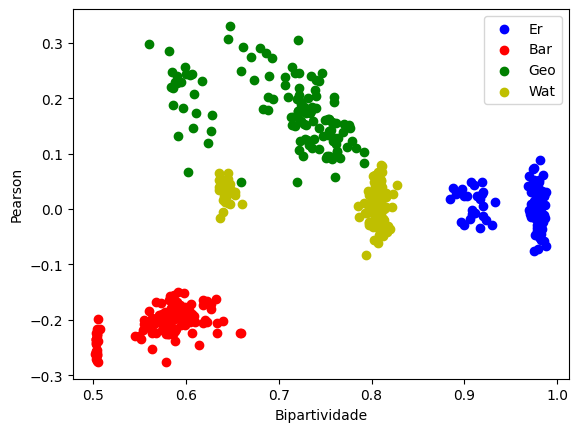

In [ ]:
plt.scatter(df["Bipartividade"][:l],df["Pearson"][:l],c='b',label=df["Classes"][0])
plt.scatter(df["Bipartividade"][l:2*l],df["Pearson"][l:2*l],c='r',label=df["Classes"][l])
plt.scatter(df["Bipartividade"][2*l:3*l],df["Pearson"][2*l:3*l],c='g',label=df["Classes"][2*l])
plt.scatter(df["Bipartividade"][3*l:4*l],df["Pearson"][3*l:4*l],c='y',label=df["Classes"][3*l])
plt.xlabel("Bipartividade")
plt.ylabel("Pearson")
plt.legend()
plt.show()

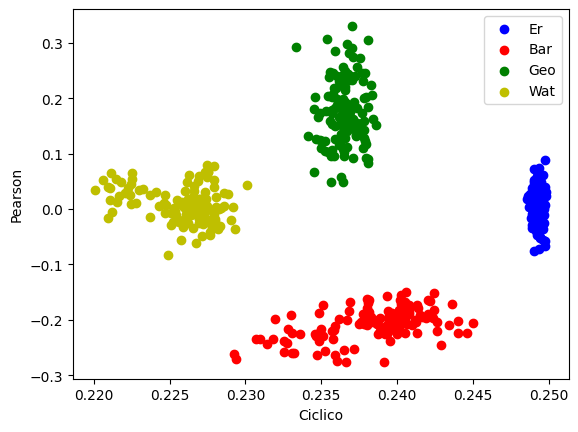

In [ ]:
plt.scatter(df["Ciclico"][:l],df["Pearson"][:l],c='b',label=df["Classes"][0])
plt.scatter(df["Ciclico"][l:2*l],df["Pearson"][l:2*l],c='r',label=df["Classes"][l])
plt.scatter(df["Ciclico"][2*l:3*l],df["Pearson"][2*l:3*l],c='g',label=df["Classes"][2*l])
plt.scatter(df["Ciclico"][3*l:4*l],df["Pearson"][3*l:4*l],c='y',label=df["Classes"][3*l])
plt.xlabel("Ciclico")
plt.ylabel("Pearson")
plt.legend()
plt.show()

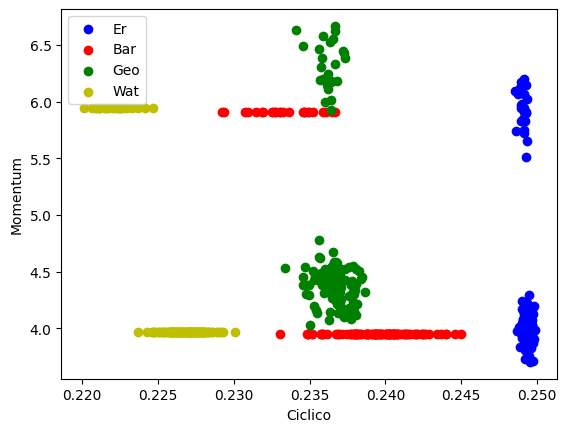

In [ ]:
plt.scatter(df["Ciclico"][:l],df["Momentum"][:l],c='b',label=df["Classes"][0])
plt.scatter(df["Ciclico"][l:2*l],df["Momentum"][l:2*l],c='r',label=df["Classes"][l])
plt.scatter(df["Ciclico"][2*l:3*l],df["Momentum"][2*l:3*l],c='g',label=df["Classes"][2*l])
plt.scatter(df["Ciclico"][3*l:4*l],df["Momentum"][3*l:4*l],c='y',label=df["Classes"][3*l])
plt.xlabel("Ciclico")
plt.ylabel("Momentum")
plt.legend()
plt.show()

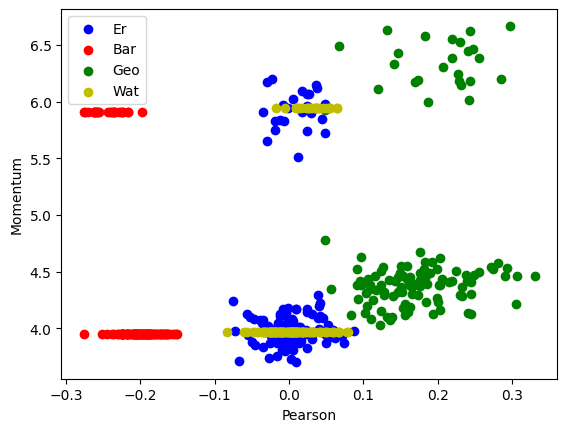

In [ ]:
plt.scatter(df["Pearson"][:l],df["Momentum"][:l],c='b',label=df["Classes"][0])
plt.scatter(df["Pearson"][l:2*l],df["Momentum"][l:2*l],c='r',label=df["Classes"][l])
plt.scatter(df["Pearson"][2*l:3*l],df["Momentum"][2*l:3*l],c='g',label=df["Classes"][2*l])
plt.scatter(df["Pearson"][3*l:4*l],df["Momentum"][3*l:4*l],c='y',label=df["Classes"][3*l])
plt.xlabel("Pearson")
plt.ylabel("Momentum")
plt.legend()
plt.show()

## Classificação de rede

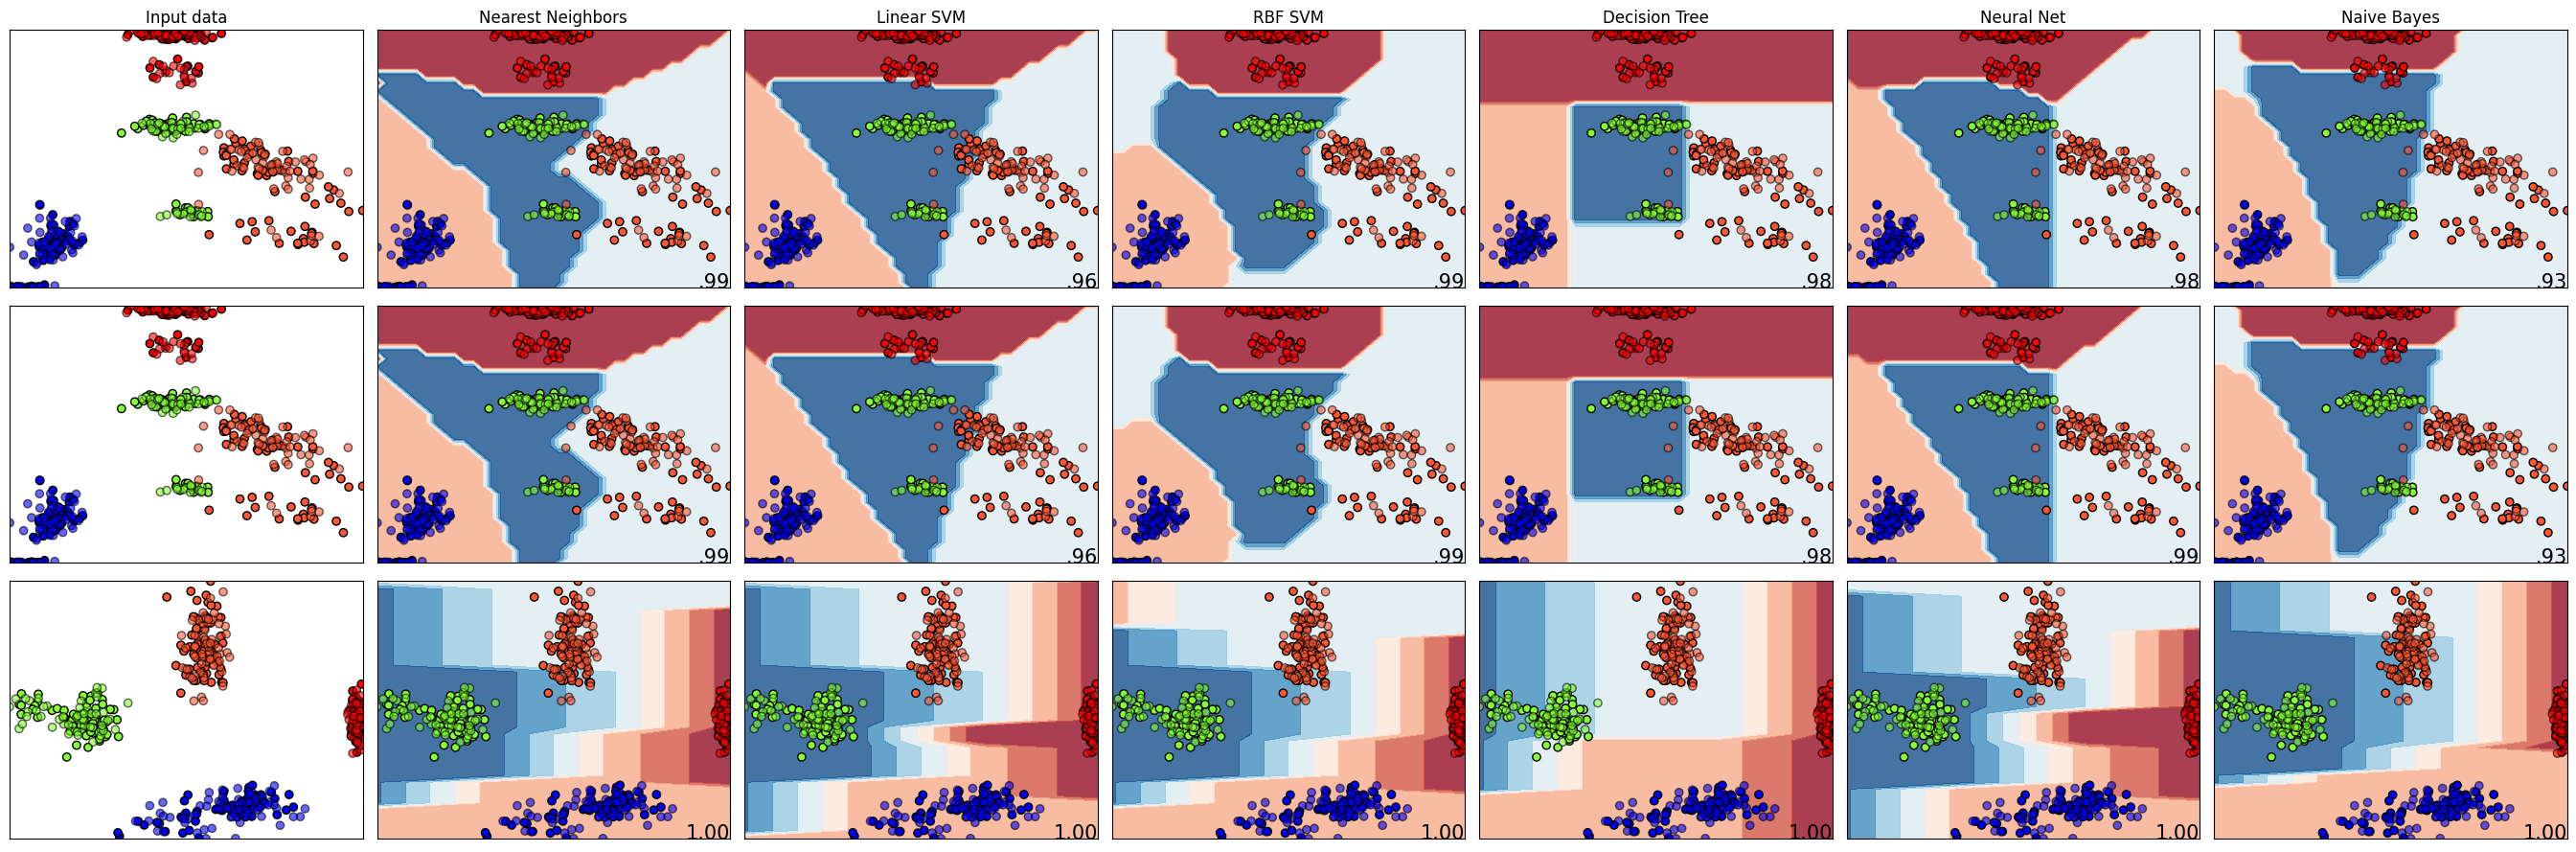

In [ ]:


names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Neural Net",
    "Naive Bayes",
    ]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB(),
]

L_dataset = []
L_classifier = []
L_accuracy = []
L_precision = []
L_recall = []
L_f1 = []
L_f1_macro = []

y=np.array(color)
data1=pd.DataFrame({"Pearson":pearson_Er+pearson_Bar+pearson_Ge+pearson_Wa
                    ,"Bipartividade":bipar_Er+bipar_Bar+bipar_Ge+bipar_Wa}).to_numpy()
data2=pd.DataFrame({"Ciclico":ciclo_Er+ciclo_Bar+ciclo_Ge+ciclo_Wa
                ,"Pearson":pearson_Er+pearson_Bar+pearson_Ge+pearson_Wa}).to_numpy()

data3=pd.DataFrame({"Ciclico":ciclo_Er+ciclo_Bar+ciclo_Ge+ciclo_Wa
                ,"Bipartividade":bipar_Er+bipar_Bar+bipar_Ge+bipar_Wa}).to_numpy()
datasets=[[data1,y],[data1,y],[data2,y]]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterações sobre os datasets
for ds_cnt, ds in enumerate(datasets):
    # separando os datasets
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=11371311
    )

    x_min, x_max = X[:, 0].min() , X[:, 0].max()
    y_min, y_max = X[:, 1].min() , X[:, 1].max()

    # configurações dos plots
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF','#FF5733','#83FF33'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # plottando o treino e teste
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterações sobre os classificadores
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )
        L_dataset.append(ds_cnt)
        L_classifier.append(name)
        L_accuracy.append(accuracy_score(y_test,y_pred))
        L_precision.append(precision_score(y_test,y_pred,average="micro"))
        L_recall.append(recall_score(y_test,y_pred,average="micro"))
        L_f1.append(f1_score(y_test,y_pred,average="micro"))
        L_f1_macro.append(f1_score(y_test,y_pred,average="macro"))
        # plot sobre o treino e o teste
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max ,
            y_min,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [ ]:

#vendo resultado
df = pd.DataFrame()
df['dataset'] = L_dataset
df['classifier'] = L_classifier
df['accuracy'] = L_accuracy
df['precision'] = L_precision
df['recall'] = L_recall
df['f1'] = L_f1
df['f1-macro'] = L_f1_macro

df

,dataset,classifier,accuracy,precision,recall,f1,f1-macro
0,0,Nearest Neighbors,0.992,0.992,0.992,0.992,0.991272
1,0,Linear SVM,0.956,0.956,0.956,0.956,0.952898
2,0,RBF SVM,0.988,0.988,0.988,0.988,0.986921
3,0,Decision Tree,0.984,0.984,0.984,0.984,0.982544
4,0,Neural Net,0.984,0.984,0.984,0.984,0.982544
5,0,Naive Bayes,0.932,0.932,0.932,0.932,0.927684
6,1,Nearest Neighbors,0.992,0.992,0.992,0.992,0.991272
7,1,Linear SVM,0.956,0.956,0.956,0.956,0.952898
8,1,RBF SVM,0.988,0.988,0.988,0.988,0.986921
9,1,Decision Tree,0.984,0.984,0.984,0.984,0.982544


### Conclusão

Podemos vê que o melhor caso é Cíclico e o Bipartido tendo aproximado de 100% de acerto, outros datasets são próximos de 100%.

## Classificação de nó

Colocamos duas técnicas para classificar nó, o primeiro é para encontrar comunidade atraves de uma classificação e o segundo DeepWalk atráves de caminha aleatória classificar o nó.

### DeepWalk
Algoritmo
- O gerador de caminhada aleatória seleciona de forma aleatória e uniforme um vértice vi como raiz do caminho aleatório $W_{vi}$, a partir de um grafo G. O caminho percorre de forma aleatória os vizinhos do último vértice visitado até alcançar o comprimento máximo (t).
- O modelo Skip-gram itera sobre todas as possíveis combinações de palavras em um caminho aleatório que estejam dentro de uma janela w. Para cada combinação, é mapeado cada vértice $v_j$ para o seu vetor de representação atual Φ(vj) ∈ $R^d$.
- Com base na representação de $v_j$, o objetivo é maximizar a probabilidade de ocorrência de seus vizinhos no caminho . Essa distribuição posterior pode ser aprendida usando diferentes tipos de classificadores.


In [24]:

# imports
import networkx as nx

import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import json


from scipy.linalg import sqrtm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from karateclub import DeepWalk, Node2Vec
from gensim.models.word2vec import Word2Vec


In [38]:
G = nx.karate_club_graph()  # carregando os grafos

clubs = []  # lista de população
for n in G.nodes:
    c = G.nodes[n]['club']
    clubs.append(1 if c == 'Officer' else 0) # adicionando

canvas = jupyter_canvas()

canvas.nodes(G.nodes).add(color="orange")
canvas.edges(G.edges).add()

canvas

JupyterWidget(events=['{"attrs": {"nodes": {"0": {"color": "orange"}, "1": {"color": "orange"}, "2": {"color":…

In [39]:
model = DeepWalk(dimensions=124)  # algoritmo de incorporação de nós
model.fit(G)  # fit
embedding = model.get_embedding()  # extração de incorporação

print('Number of karate club members:', len(G.nodes))
print('Embedding array shape:', embedding.shape)

Number of karate club members: 34
Embedding array shape: (34, 124)


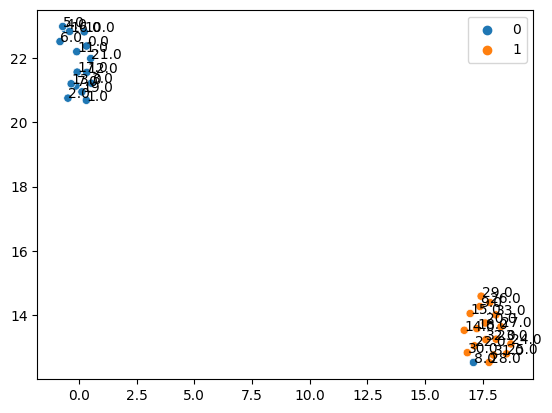

In [27]:
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(embedding)

ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = clubs)
a = pd.DataFrame({'x': umap_embs[:, 0], 'y': umap_embs[:, 1], 'val': G.nodes})
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], str(point['val']))